## Dataloader

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import numpy as np
from torchsummary import summary


class CustomDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        if train:
            self.image_folder = os.path.join(root_dir, 'train')
            self.mask_folder = os.path.join(root_dir, 'train_masks')
        else:
            self.image_folder = os.path.join(root_dir, 'test')
            self.mask_folder = os.path.join(root_dir, 'test_masks')

        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        mask_name = os.path.join(self.mask_folder, self.mask_files[idx])

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
  
    
])


# Create custom dataset for training
train_dataset = CustomDataset(root_dir='/media/cvlab/EXT_HARD_DRIVE/Karan/A2/dataset/ISIC 2016', train=True, transform=transform)


# Split the dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)  
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False,pin_memory=True)

# Create custom dataset for testing
test_dataset = CustomDataset(root_dir='/media/cvlab/EXT_HARD_DRIVE/Karan/A2/dataset/ISIC 2016', train=False, transform=transform)

# Create DataLoader for testing
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)  



## Model 1 (with features taken from last layer only)
## (Without Fine Tuning)

In [2]:
import torch.nn as nn
from torchvision import models
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        # Upsampling layers
        self.conv1 = nn.Conv2d(1280, 320, kernel_size=1, stride=1, padding=0)
        self.norm1 = nn.BatchNorm2d(320)
        self.relu1 = nn.ReLU6(inplace=True)
        self.ir_block1 = InvertedResidual(320, 320)
        
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv2 = nn.Conv2d(320, 960, kernel_size=1, stride=1, padding=0)
        self.norm2 = nn.BatchNorm2d(960)
        self.relu2 = nn.ReLU6(inplace=True)
        self.ir_block2 = InvertedResidual(960, 960)
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv3 = nn.Conv2d(960, 960, kernel_size=1, stride=1, padding=0)
        self.norm3 = nn.BatchNorm2d(960)
        self.relu3 = nn.ReLU6(inplace=True)
        self.ir_block3 = InvertedResidual(960, 960)
        
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv4 = nn.Conv2d(960, 320, kernel_size=1, stride=1, padding=0)
        self.norm4 = nn.BatchNorm2d(320)
        self.relu4 = nn.ReLU6(inplace=True)
        self.ir_block4 = InvertedResidual(320, 320)
        
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv5 = nn.Conv2d(320, 160, kernel_size=1, stride=1, padding=0)
        self.norm5 = nn.BatchNorm2d(160)
        self.relu5 = nn.ReLU6(inplace=True)
        self.ir_block5 = InvertedResidual(160, 160)
        
        self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv6 = nn.Conv2d(160, 160, kernel_size=1, stride=1, padding=0)
        self.norm6 = nn.BatchNorm2d(160)
        self.relu6 = nn.ReLU6(inplace=True)
        self.ir_block6 = InvertedResidual(160, 160)
        
        self.up6 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv7 = nn.Conv2d(160, 32, kernel_size=1, stride=1, padding=0)
        self.norm7 = nn.BatchNorm2d(32)
        self.relu7 = nn.ReLU6(inplace=True)
        self.ir_block7 = InvertedResidual(32, 32)
        
        self.up7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv8 = nn.Conv2d(32, 24, kernel_size=1, stride=1, padding=0)
        self.norm8 = nn.BatchNorm2d(24)
        self.relu8 = nn.ReLU6(inplace=True)
        self.ir_block8 = InvertedResidual(24, 24)
        
        self.up8 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv9 = nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0)
        self.norm9 = nn.BatchNorm2d(16)
        self.relu9 = nn.ReLU6(inplace=True)
        self.ir_block9 = InvertedResidual(16, 16)
        
        self.up9 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv10 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.norm10 = nn.BatchNorm2d(16)
        self.relu10 = nn.ReLU6(inplace=True)
        
        self.conv11 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
                                           
        
    
    def forward(self, x):
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.ir_block1(x)
        x = self.up1(x)
        
        x = self.relu2(self.norm2(self.conv2(x)))
        x = self.ir_block2(x)
        x = self.up2(x)
        
        x = self.relu3(self.norm3(self.conv3(x)))
        x = self.ir_block3(x)
        x = self.up3(x)
        
        x = self.relu4(self.norm4(self.conv4(x)))
        x = self.ir_block4(x)
        x = self.up4(x)
        
        x = self.relu5(self.norm5(self.conv5(x)))
        x = self.ir_block5(x)
        x = self.up5(x)
        
        x = self.relu6(self.norm6(self.conv6(x)))
        x = self.ir_block6(x)
        # x = self.up6(x)
        
        x = self.relu7(self.norm7(self.conv7(x)))
        x = self.ir_block7(x)
        # x = self.up7(x)
        
        x = self.relu8(self.norm8(self.conv8(x)))
        x = self.ir_block8(x)
        # x = self.up8(x)
        
        x = self.relu9(self.norm9(self.conv9(x)))
        x = self.ir_block9(x)
        # x = self.up9(x)
        
        x = self.relu10(self.norm10(self.conv10(x)))
        x = self.conv11(x)
        
        return x

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(InvertedResidual, self).__init__()
        
        self.stride = stride
        
        if stride == 1:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, dilation=2)
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU6(inplace=True)
        
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.norm2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU6(inplace=True)
    
    def forward(self, x):
        residual = x
        
        out = self.relu1(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))
        
        if self.stride == 1:
            out += residual
        
        out = self.relu2(out)
        
        return out


    
class CustomSegmentationModel(nn.Module):
    def __init__(self, num_classes, fine_tune_encoder=False):
        super(CustomSegmentationModel, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.encoder = models.mobilenet_v2(pretrained=True).features

        # Freeze encoder weights if not fine-tuning
        if not fine_tune_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # Define custom decoder
        self.final_conv = Decoder()
    def forward(self, x):
        # Forward pass through the encoder
        x = self.encoder(x)

        # Forward pass through the decoder
        x = self.final_conv(x)
        # print("x size: ", x.size())
        return x
    
num_classes = 1  
model = CustomSegmentationModel(num_classes, fine_tune_encoder=False)

# Print the model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 128,128))  # Adjust input shape as needed

/home/cvlab/miniconda3/envs/loc1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cvlab/miniconda3/envs/loc1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

### Training Loop

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_iou(outputs, targets, threshold=0.5):
    # Convert outputs and targets to binary masks
    outputs = (outputs > threshold).long()
    targets = (targets > 0.5).long()
    
    intersection = (outputs & targets).float().sum((1, 2))
    union = (outputs | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add epsilon to avoid division by zero
    return iou.mean().item()

# Define Dice loss function
def dice_loss(input, target, smooth=1):
    input = torch.sigmoid(input)
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Define combined loss function
def combined_loss(input, target, alpha=0.5):
    bce_loss = nn.BCEWithLogitsLoss()(input, target)
    dice = dice_loss(input, target)
    combined = alpha * bce_loss + (1 - alpha) * dice
    return combined

# Define loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define loss function and optimizer with SGD and momentum
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# Training loop
num_epochs = 50

# Initialize variables for best loss and best model weights
best_loss = float('inf')
best_weights = None

# Lists to store training and validation losses
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_iou_train = 0.0
    total_batches_train = 0
    
    for i, data in enumerate(tqdm(train_dataloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Calculate combined loss
        loss = combined_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate IoU for training accuracy
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()
        total_iou_train += calculate_iou(predicted_masks, labels)
        total_batches_train += 1
    
    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = total_iou_train / total_batches_train
    train_accs.append(train_acc)
    
    # Check if current epoch has the best validation loss
    if loss < best_loss:
        best_loss = loss
        best_weights = model.state_dict()

    # Validation
    model.eval()
    val_loss = 0.0
    total_iou_val = 0.0
    total_batches_val = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # Calculate combined loss for validation
            loss = combined_loss(outputs, labels)
            val_loss += loss.item()
            
            # Calculate IoU for validation accuracy
            predicted_masks = torch.sigmoid(outputs) > 0.5
            predicted_masks = predicted_masks.bool()
            total_iou_val += calculate_iou(predicted_masks, labels)
            total_batches_val += 1
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = total_iou_val / total_batches_val
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Training IoU: {train_acc:.4f}, '
          f'Validation IoU: {val_acc:.4f}')
    
torch.save(model.state_dict(), 'trained_model_big_1.pth')

100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [1/50], Training Loss: 0.6592, Validation Loss: 0.6604, Training IoU: 0.0714, Validation IoU: 0.4702


100%|██████████| 13/13 [00:47<00:00,  3.68s/it]


Epoch [2/50], Training Loss: 0.6080, Validation Loss: 0.6618, Training IoU: 0.2867, Validation IoU: 0.1621


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [3/50], Training Loss: 0.5691, Validation Loss: 0.6402, Training IoU: 0.2937, Validation IoU: 0.2687


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [4/50], Training Loss: 0.5335, Validation Loss: 0.5668, Training IoU: 0.3699, Validation IoU: 0.3641


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


Epoch [5/50], Training Loss: 0.4912, Validation Loss: 0.5021, Training IoU: 0.4635, Validation IoU: 0.4486


100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


Epoch [6/50], Training Loss: 0.4383, Validation Loss: 0.4572, Training IoU: 0.5299, Validation IoU: 0.4915


100%|██████████| 13/13 [00:46<00:00,  3.61s/it]


Epoch [7/50], Training Loss: 0.3831, Validation Loss: 0.4208, Training IoU: 0.5926, Validation IoU: 0.5327


100%|██████████| 13/13 [00:46<00:00,  3.60s/it]


Epoch [8/50], Training Loss: 0.3456, Validation Loss: 0.3958, Training IoU: 0.6311, Validation IoU: 0.5663


100%|██████████| 13/13 [00:47<00:00,  3.63s/it]


Epoch [9/50], Training Loss: 0.3156, Validation Loss: 0.3822, Training IoU: 0.6636, Validation IoU: 0.5997


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [10/50], Training Loss: 0.2820, Validation Loss: 0.3669, Training IoU: 0.6962, Validation IoU: 0.6205


100%|██████████| 13/13 [00:46<00:00,  3.60s/it]


Epoch [11/50], Training Loss: 0.2675, Validation Loss: 0.3520, Training IoU: 0.7124, Validation IoU: 0.6510


100%|██████████| 13/13 [00:47<00:00,  3.68s/it]


Epoch [12/50], Training Loss: 0.2493, Validation Loss: 0.3450, Training IoU: 0.7243, Validation IoU: 0.6475


100%|██████████| 13/13 [00:47<00:00,  3.63s/it]


Epoch [13/50], Training Loss: 0.2413, Validation Loss: 0.3383, Training IoU: 0.7361, Validation IoU: 0.6521


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [14/50], Training Loss: 0.2314, Validation Loss: 0.3323, Training IoU: 0.7451, Validation IoU: 0.6584


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [15/50], Training Loss: 0.2138, Validation Loss: 0.3258, Training IoU: 0.7593, Validation IoU: 0.6758


100%|██████████| 13/13 [00:47<00:00,  3.68s/it]


Epoch [16/50], Training Loss: 0.2134, Validation Loss: 0.3296, Training IoU: 0.7614, Validation IoU: 0.6821


100%|██████████| 13/13 [00:47<00:00,  3.63s/it]


Epoch [17/50], Training Loss: 0.2041, Validation Loss: 0.3336, Training IoU: 0.7710, Validation IoU: 0.6743


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [18/50], Training Loss: 0.1977, Validation Loss: 0.3271, Training IoU: 0.7747, Validation IoU: 0.6794


100%|██████████| 13/13 [00:46<00:00,  3.61s/it]


Epoch [19/50], Training Loss: 0.1908, Validation Loss: 0.3350, Training IoU: 0.7853, Validation IoU: 0.6894


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [20/50], Training Loss: 0.1839, Validation Loss: 0.3351, Training IoU: 0.7894, Validation IoU: 0.6695


100%|██████████| 13/13 [00:48<00:00,  3.70s/it]


Epoch [21/50], Training Loss: 0.1756, Validation Loss: 0.3271, Training IoU: 0.7978, Validation IoU: 0.6828


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [22/50], Training Loss: 0.1671, Validation Loss: 0.3262, Training IoU: 0.8060, Validation IoU: 0.6932


100%|██████████| 13/13 [00:46<00:00,  3.54s/it]


Epoch [23/50], Training Loss: 0.1696, Validation Loss: 0.3263, Training IoU: 0.8032, Validation IoU: 0.6876


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [24/50], Training Loss: 0.1672, Validation Loss: 0.3318, Training IoU: 0.8071, Validation IoU: 0.6962


100%|██████████| 13/13 [00:47<00:00,  3.64s/it]


Epoch [25/50], Training Loss: 0.1642, Validation Loss: 0.3198, Training IoU: 0.8093, Validation IoU: 0.6919


100%|██████████| 13/13 [00:47<00:00,  3.63s/it]


Epoch [26/50], Training Loss: 0.1581, Validation Loss: 0.3199, Training IoU: 0.8146, Validation IoU: 0.6977


100%|██████████| 13/13 [00:47<00:00,  3.63s/it]


Epoch [27/50], Training Loss: 0.1568, Validation Loss: 0.3234, Training IoU: 0.8165, Validation IoU: 0.7009


100%|██████████| 13/13 [00:46<00:00,  3.59s/it]


Epoch [28/50], Training Loss: 0.1488, Validation Loss: 0.3194, Training IoU: 0.8254, Validation IoU: 0.7067


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [29/50], Training Loss: 0.1447, Validation Loss: 0.3221, Training IoU: 0.8289, Validation IoU: 0.7081


100%|██████████| 13/13 [00:46<00:00,  3.61s/it]


Epoch [30/50], Training Loss: 0.1487, Validation Loss: 0.3201, Training IoU: 0.8234, Validation IoU: 0.7072


100%|██████████| 13/13 [00:46<00:00,  3.56s/it]


Epoch [31/50], Training Loss: 0.1392, Validation Loss: 0.3274, Training IoU: 0.8318, Validation IoU: 0.7039


100%|██████████| 13/13 [00:47<00:00,  3.64s/it]


Epoch [32/50], Training Loss: 0.1409, Validation Loss: 0.3275, Training IoU: 0.8319, Validation IoU: 0.6975


100%|██████████| 13/13 [00:47<00:00,  3.63s/it]


Epoch [33/50], Training Loss: 0.1369, Validation Loss: 0.3264, Training IoU: 0.8369, Validation IoU: 0.7048


100%|██████████| 13/13 [00:46<00:00,  3.60s/it]


Epoch [34/50], Training Loss: 0.1369, Validation Loss: 0.3268, Training IoU: 0.8355, Validation IoU: 0.7050


100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Epoch [35/50], Training Loss: 0.1292, Validation Loss: 0.3351, Training IoU: 0.8434, Validation IoU: 0.7074


100%|██████████| 13/13 [00:47<00:00,  3.66s/it]


Epoch [36/50], Training Loss: 0.1445, Validation Loss: 0.3336, Training IoU: 0.8310, Validation IoU: 0.6964


100%|██████████| 13/13 [00:48<00:00,  3.69s/it]


Epoch [37/50], Training Loss: 0.1377, Validation Loss: 0.3305, Training IoU: 0.8350, Validation IoU: 0.7027


100%|██████████| 13/13 [00:47<00:00,  3.67s/it]


Epoch [38/50], Training Loss: 0.1267, Validation Loss: 0.3333, Training IoU: 0.8455, Validation IoU: 0.7044


100%|██████████| 13/13 [00:46<00:00,  3.61s/it]


Epoch [39/50], Training Loss: 0.1225, Validation Loss: 0.3349, Training IoU: 0.8494, Validation IoU: 0.7036


100%|██████████| 13/13 [00:47<00:00,  3.63s/it]


Epoch [40/50], Training Loss: 0.1285, Validation Loss: 0.3355, Training IoU: 0.8438, Validation IoU: 0.7018


100%|██████████| 13/13 [00:47<00:00,  3.62s/it]


Epoch [41/50], Training Loss: 0.1202, Validation Loss: 0.3273, Training IoU: 0.8533, Validation IoU: 0.7077


100%|██████████| 13/13 [00:46<00:00,  3.58s/it]


Epoch [42/50], Training Loss: 0.1271, Validation Loss: 0.3361, Training IoU: 0.8462, Validation IoU: 0.7019


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [43/50], Training Loss: 0.1267, Validation Loss: 0.3430, Training IoU: 0.8481, Validation IoU: 0.7095


100%|██████████| 13/13 [00:46<00:00,  3.55s/it]


Epoch [44/50], Training Loss: 0.1343, Validation Loss: 0.3344, Training IoU: 0.8430, Validation IoU: 0.7104


100%|██████████| 13/13 [00:46<00:00,  3.60s/it]


Epoch [45/50], Training Loss: 0.1221, Validation Loss: 0.3281, Training IoU: 0.8499, Validation IoU: 0.7094


100%|██████████| 13/13 [00:46<00:00,  3.57s/it]


Epoch [46/50], Training Loss: 0.1207, Validation Loss: 0.3252, Training IoU: 0.8530, Validation IoU: 0.7135


100%|██████████| 13/13 [00:46<00:00,  3.58s/it]


Epoch [47/50], Training Loss: 0.1153, Validation Loss: 0.3279, Training IoU: 0.8577, Validation IoU: 0.7093


100%|██████████| 13/13 [00:46<00:00,  3.59s/it]


Epoch [48/50], Training Loss: 0.1179, Validation Loss: 0.3376, Training IoU: 0.8552, Validation IoU: 0.7115


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [49/50], Training Loss: 0.1131, Validation Loss: 0.3408, Training IoU: 0.8598, Validation IoU: 0.7074


100%|██████████| 13/13 [00:47<00:00,  3.67s/it]


Epoch [50/50], Training Loss: 0.1139, Validation Loss: 0.3317, Training IoU: 0.8589, Validation IoU: 0.7114


### Curves

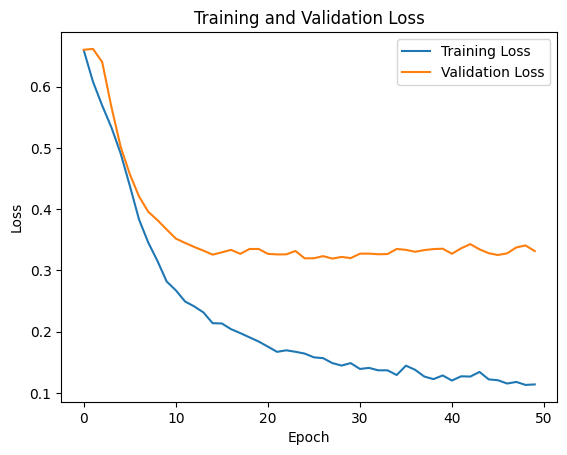

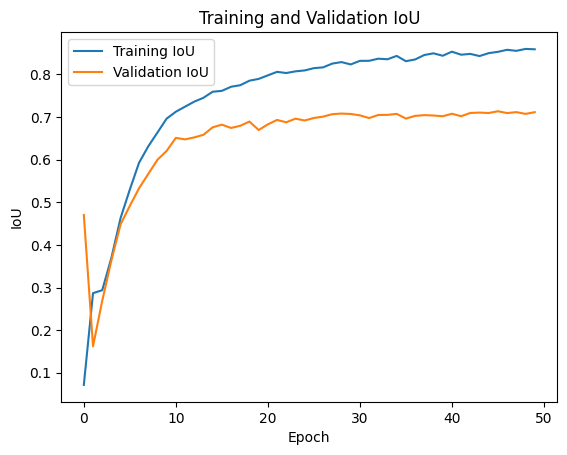

In [4]:
# Plotting training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation IoU
plt.plot(train_accs, label='Training IoU')
plt.plot(val_accs, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

### IOU and Dice Score

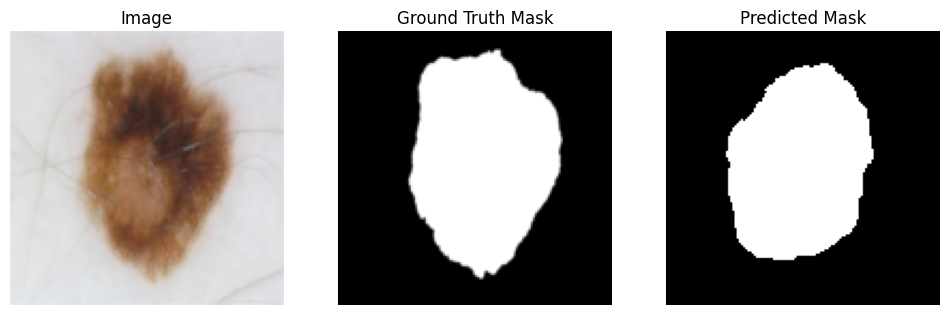

IoU: 0.7192126240442492, Dice Score: 0.862109701748698


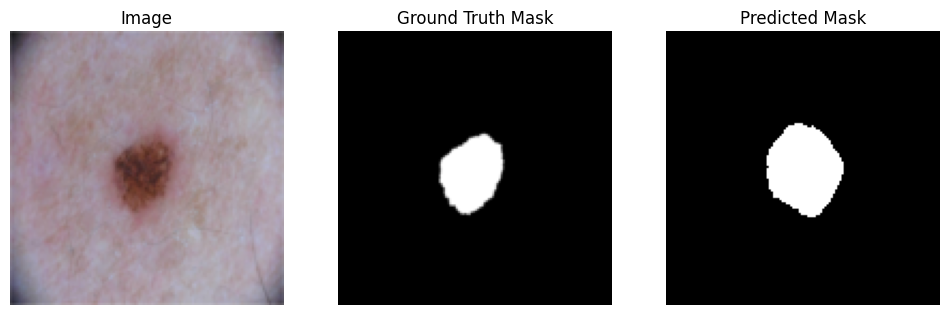

IoU: 0.7171548117154811, Dice Score: 0.8858473508024373


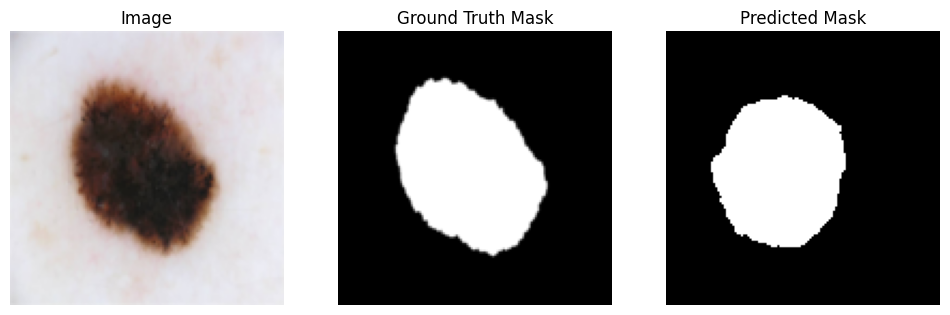

IoU: 0.6532153646957273, Dice Score: 0.8180148918049154


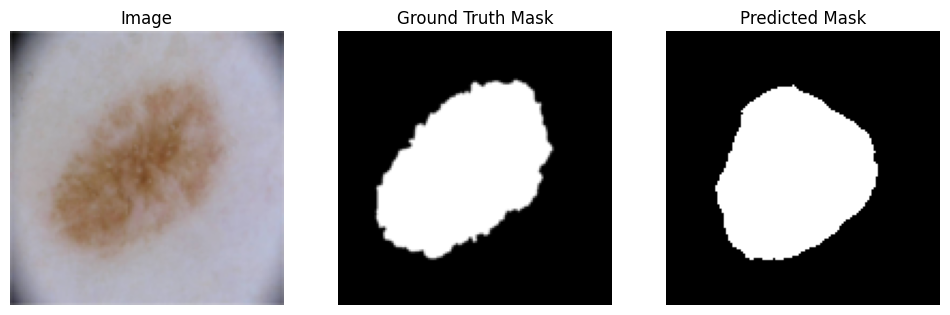

IoU: 0.7670107033639144, Dice Score: 0.8982664271471397


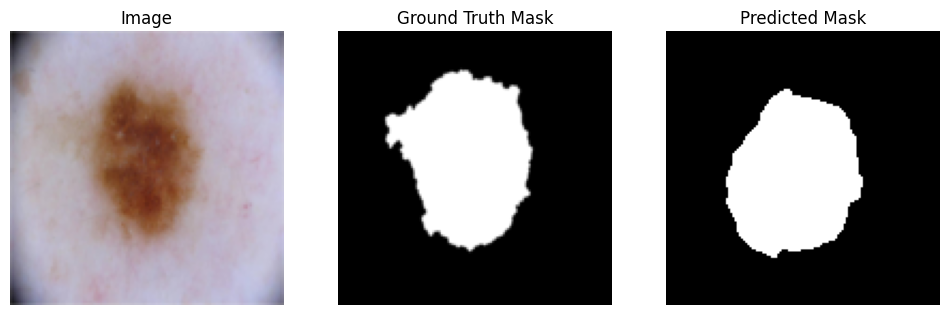

IoU: 0.7064340239912759, Dice Score: 0.8614693962468165


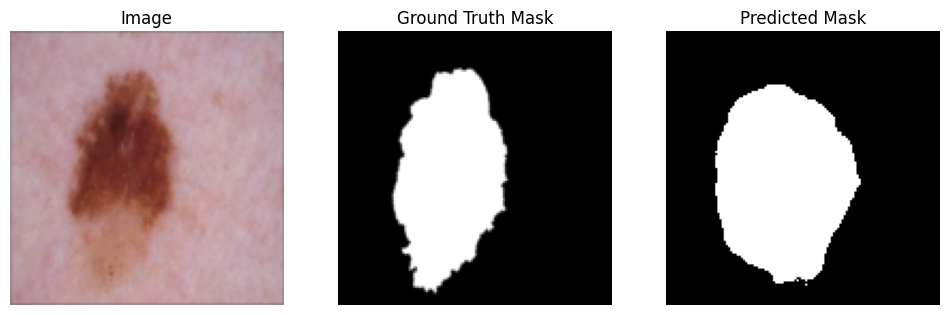

IoU: 0.7279165846940783, Dice Score: 0.8728292223168342


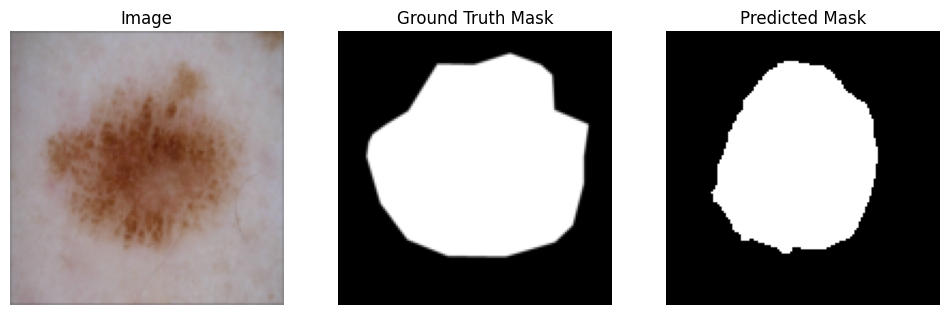

IoU: 0.670919031502213, Dice Score: 0.823652132223914


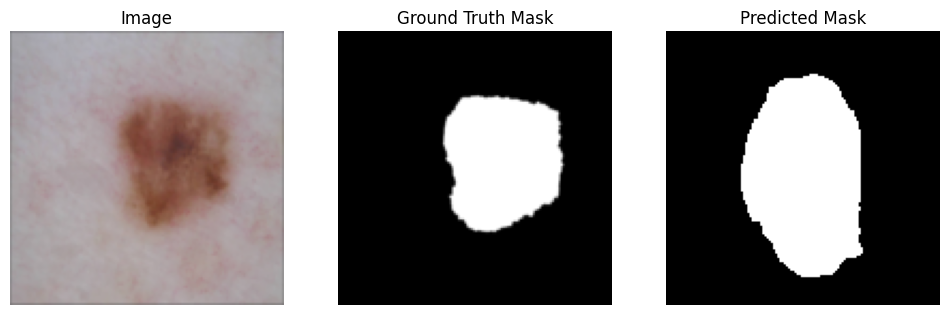

IoU: 0.48029256399837467, Dice Score: 0.669222600807032


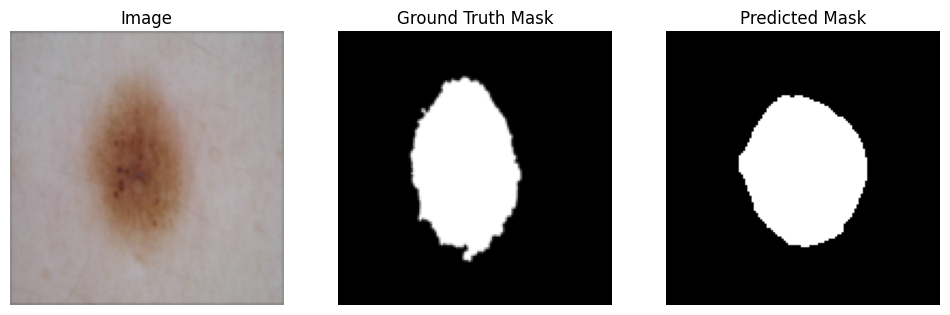

IoU: 0.7258541834813022, Dice Score: 0.8761547339991079


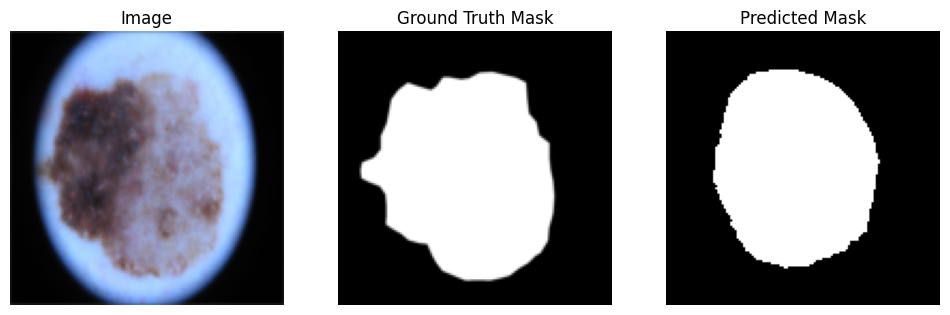

IoU: 0.7975182481751825, Dice Score: 0.9100886529639842
IoU: 0.660720451145126, Dice Score: 0.819750422213473
IoU: 0.6197056173024933, Dice Score: 0.8036575818052196
IoU: 0.5748526018969495, Dice Score: 0.749862787864855
IoU: 0.825560697757209, Dice Score: 0.9233947664512998
IoU: 0.7340574960202266, Dice Score: 0.8696678492807838
IoU: 0.798607318405243, Dice Score: 0.9153148510635989
IoU: 0.5850536746490503, Dice Score: 0.7613151213349123
IoU: 0.674884437596302, Dice Score: 0.833981873853312
IoU: 0.6675534991324465, Dice Score: 0.8232861011651381
IoU: 0.6401840490797546, Dice Score: 0.8099007713447153
IoU: 0.4516036655211913, Dice Score: 0.6408765794388086
IoU: 0.4678687008784096, Dice Score: 0.6752819381982477
IoU: 0.7515251055842328, Dice Score: 0.8948285146324154
IoU: 0.6301624129930394, Dice Score: 0.8074917267333793
IoU: 0.0, Dice Score: 0.0
IoU: 0.4627083942673296, Dice Score: 0.6530816285516803
IoU: 0.6955489614243323, Dice Score: 0.8460438077938848
IoU: 0.6256744186046511, Dice

In [5]:
import torch
import matplotlib.pyplot as plt

# Load the saved model for testing
loaded_model = CustomSegmentationModel(1)  
loaded_model.load_state_dict(torch.load('trained_model_big_1.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Function to calculate IoU
def calculate_iou(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    union = torch.logical_or(gt_mask, predicted_mask).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

# Function to calculate Dice score
def calculate_dice(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    dice = 2 * intersection / (gt_mask.sum().item() + predicted_mask.sum().item())
    return dice

# Function to visualize image, ground truth mask, and predicted mask
def visualize_sample(image, gt_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(gt_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

iou_total = 0
dice_total = 0
num_samples = 0
num_visualized = 0  # Initialize a counter for the number of visualized images
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, masks = data
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()

        
        for j in range(len(images)):
            if num_visualized < 10:  # Visualize only 10 images
                visualize_sample(images[j].cpu(), masks[j].cpu(), predicted_masks[j].cpu())
                num_visualized += 1
            
            iou = calculate_iou(masks[j], predicted_masks[j])
            dice = calculate_dice(masks[j], predicted_masks[j])
            iou_total += iou
            dice_total += dice
            num_samples += 1

            print(f"IoU: {iou}, Dice Score: {dice}")


# Calculate average IoU and Dice score
avg_iou = iou_total / num_samples
avg_dice = dice_total / num_samples

print(f"Average IoU: {avg_iou}, Average Dice Score: {avg_dice}")


## Model 1 (with features taken from last layer only)
## (With Fine Tuning)

In [6]:
num_classes = 1  
model = CustomSegmentationModel(num_classes, fine_tune_encoder=True)

# Print the model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 128,128))  # Adjust input shape as needed

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

### Training Loop

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_iou(outputs, targets, threshold=0.5):
    # Convert outputs and targets to binary masks
    outputs = (outputs > threshold).long()
    targets = (targets > 0.5).long()
    
    intersection = (outputs & targets).float().sum((1, 2))
    union = (outputs | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add epsilon to avoid division by zero
    return iou.mean().item()

# Define Dice loss function
def dice_loss(input, target, smooth=1):
    input = torch.sigmoid(input)
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Define combined loss function
def combined_loss(input, target, alpha=0.5):
    bce_loss = nn.BCEWithLogitsLoss()(input, target)
    dice = dice_loss(input, target)
    combined = alpha * bce_loss + (1 - alpha) * dice
    return combined

# Define loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define loss function and optimizer with SGD and momentum
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# Training loop
num_epochs = 50

# Initialize variables for best loss and best model weights
best_loss = float('inf')
best_weights = None

# Lists to store training and validation losses
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_iou_train = 0.0
    total_batches_train = 0
    
    for i, data in enumerate(tqdm(train_dataloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Calculate combined loss
        loss = combined_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate IoU for training accuracy
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()
        total_iou_train += calculate_iou(predicted_masks, labels)
        total_batches_train += 1
    
    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = total_iou_train / total_batches_train
    train_accs.append(train_acc)
    
    # Check if current epoch has the best validation loss
    if loss < best_loss:
        best_loss = loss
        best_weights = model.state_dict()

    # Validation
    model.eval()
    val_loss = 0.0
    total_iou_val = 0.0
    total_batches_val = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # Calculate combined loss for validation
            loss = combined_loss(outputs, labels)
            val_loss += loss.item()
            
            # Calculate IoU for validation accuracy
            predicted_masks = torch.sigmoid(outputs) > 0.5
            predicted_masks = predicted_masks.bool()
            total_iou_val += calculate_iou(predicted_masks, labels)
            total_batches_val += 1
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = total_iou_val / total_batches_val
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Training IoU: {train_acc:.4f}, '
          f'Validation IoU: {val_acc:.4f}')
    
torch.save(model.state_dict(), 'trained_model_big_2.pth')

100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [1/50], Training Loss: 0.6801, Validation Loss: 0.6696, Training IoU: 0.1683, Validation IoU: 0.1570


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [2/50], Training Loss: 0.6210, Validation Loss: 0.6626, Training IoU: 0.2480, Validation IoU: 0.0679


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Epoch [3/50], Training Loss: 0.5734, Validation Loss: 0.6474, Training IoU: 0.4057, Validation IoU: 0.1670


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [4/50], Training Loss: 0.5374, Validation Loss: 0.5759, Training IoU: 0.4026, Validation IoU: 0.3761


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [5/50], Training Loss: 0.5037, Validation Loss: 0.5278, Training IoU: 0.4932, Validation IoU: 0.4533


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [6/50], Training Loss: 0.4653, Validation Loss: 0.4678, Training IoU: 0.5358, Validation IoU: 0.5190


100%|██████████| 13/13 [00:47<00:00,  3.68s/it]


Epoch [7/50], Training Loss: 0.4201, Validation Loss: 0.4335, Training IoU: 0.5665, Validation IoU: 0.5467


100%|██████████| 13/13 [00:48<00:00,  3.77s/it]


Epoch [8/50], Training Loss: 0.3656, Validation Loss: 0.3947, Training IoU: 0.6104, Validation IoU: 0.5661


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [9/50], Training Loss: 0.3225, Validation Loss: 0.3496, Training IoU: 0.6469, Validation IoU: 0.6151


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Epoch [10/50], Training Loss: 0.2886, Validation Loss: 0.3439, Training IoU: 0.6853, Validation IoU: 0.6452


100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


Epoch [11/50], Training Loss: 0.2706, Validation Loss: 0.3563, Training IoU: 0.7116, Validation IoU: 0.6367


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [12/50], Training Loss: 0.2468, Validation Loss: 0.3003, Training IoU: 0.7383, Validation IoU: 0.6991


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [13/50], Training Loss: 0.2305, Validation Loss: 0.3026, Training IoU: 0.7570, Validation IoU: 0.7014


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [14/50], Training Loss: 0.2106, Validation Loss: 0.2769, Training IoU: 0.7742, Validation IoU: 0.7249


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [15/50], Training Loss: 0.2019, Validation Loss: 0.2478, Training IoU: 0.7877, Validation IoU: 0.7497


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Epoch [16/50], Training Loss: 0.1800, Validation Loss: 0.2453, Training IoU: 0.8040, Validation IoU: 0.7548


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Epoch [17/50], Training Loss: 0.1673, Validation Loss: 0.2342, Training IoU: 0.8139, Validation IoU: 0.7637


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [18/50], Training Loss: 0.1601, Validation Loss: 0.2306, Training IoU: 0.8229, Validation IoU: 0.7711


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [19/50], Training Loss: 0.1475, Validation Loss: 0.2399, Training IoU: 0.8329, Validation IoU: 0.7596


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [20/50], Training Loss: 0.1486, Validation Loss: 0.2452, Training IoU: 0.8339, Validation IoU: 0.7675


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [21/50], Training Loss: 0.1356, Validation Loss: 0.2261, Training IoU: 0.8456, Validation IoU: 0.7802


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [22/50], Training Loss: 0.1294, Validation Loss: 0.2223, Training IoU: 0.8499, Validation IoU: 0.7765


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [23/50], Training Loss: 0.1283, Validation Loss: 0.2210, Training IoU: 0.8514, Validation IoU: 0.7803


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [24/50], Training Loss: 0.1247, Validation Loss: 0.2207, Training IoU: 0.8552, Validation IoU: 0.7840


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [25/50], Training Loss: 0.1225, Validation Loss: 0.2158, Training IoU: 0.8567, Validation IoU: 0.7886


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


Epoch [26/50], Training Loss: 0.1249, Validation Loss: 0.2253, Training IoU: 0.8563, Validation IoU: 0.7793


100%|██████████| 13/13 [00:48<00:00,  3.77s/it]


Epoch [27/50], Training Loss: 0.1138, Validation Loss: 0.2121, Training IoU: 0.8651, Validation IoU: 0.7941


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [28/50], Training Loss: 0.1062, Validation Loss: 0.2142, Training IoU: 0.8709, Validation IoU: 0.7889


100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


Epoch [29/50], Training Loss: 0.1109, Validation Loss: 0.2205, Training IoU: 0.8685, Validation IoU: 0.7879


100%|██████████| 13/13 [00:48<00:00,  3.77s/it]


Epoch [30/50], Training Loss: 0.1009, Validation Loss: 0.2153, Training IoU: 0.8766, Validation IoU: 0.7967


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [31/50], Training Loss: 0.1002, Validation Loss: 0.2218, Training IoU: 0.8782, Validation IoU: 0.7958


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [32/50], Training Loss: 0.0991, Validation Loss: 0.2259, Training IoU: 0.8802, Validation IoU: 0.7927


100%|██████████| 13/13 [00:50<00:00,  3.86s/it]


Epoch [33/50], Training Loss: 0.1089, Validation Loss: 0.2278, Training IoU: 0.8718, Validation IoU: 0.7863


100%|██████████| 13/13 [00:48<00:00,  3.70s/it]


Epoch [34/50], Training Loss: 0.0924, Validation Loss: 0.2138, Training IoU: 0.8849, Validation IoU: 0.7978


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [35/50], Training Loss: 0.0967, Validation Loss: 0.2164, Training IoU: 0.8828, Validation IoU: 0.7936


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [36/50], Training Loss: 0.0873, Validation Loss: 0.2257, Training IoU: 0.8901, Validation IoU: 0.7910


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Epoch [37/50], Training Loss: 0.0897, Validation Loss: 0.2228, Training IoU: 0.8892, Validation IoU: 0.7988


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [38/50], Training Loss: 0.0959, Validation Loss: 0.2225, Training IoU: 0.8824, Validation IoU: 0.7959


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [39/50], Training Loss: 0.0837, Validation Loss: 0.2252, Training IoU: 0.8949, Validation IoU: 0.7926


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [40/50], Training Loss: 0.0888, Validation Loss: 0.2154, Training IoU: 0.8902, Validation IoU: 0.7979


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [41/50], Training Loss: 0.0892, Validation Loss: 0.2158, Training IoU: 0.8894, Validation IoU: 0.7977


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [42/50], Training Loss: 0.0807, Validation Loss: 0.2143, Training IoU: 0.8975, Validation IoU: 0.7984


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [43/50], Training Loss: 0.0775, Validation Loss: 0.2261, Training IoU: 0.9005, Validation IoU: 0.7938


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [44/50], Training Loss: 0.0910, Validation Loss: 0.2264, Training IoU: 0.8897, Validation IoU: 0.7934


100%|██████████| 13/13 [00:50<00:00,  3.90s/it]


Epoch [45/50], Training Loss: 0.0763, Validation Loss: 0.2222, Training IoU: 0.9027, Validation IoU: 0.7973


100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


Epoch [46/50], Training Loss: 0.0817, Validation Loss: 0.2217, Training IoU: 0.8971, Validation IoU: 0.7982


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [47/50], Training Loss: 0.0773, Validation Loss: 0.2245, Training IoU: 0.9007, Validation IoU: 0.7957


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [48/50], Training Loss: 0.0759, Validation Loss: 0.2232, Training IoU: 0.9034, Validation IoU: 0.8013


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [49/50], Training Loss: 0.0803, Validation Loss: 0.2211, Training IoU: 0.8989, Validation IoU: 0.7989


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [50/50], Training Loss: 0.0814, Validation Loss: 0.2255, Training IoU: 0.8974, Validation IoU: 0.7938


### Curves

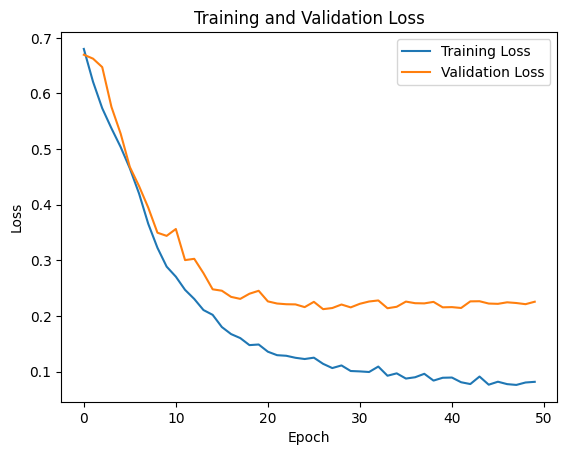

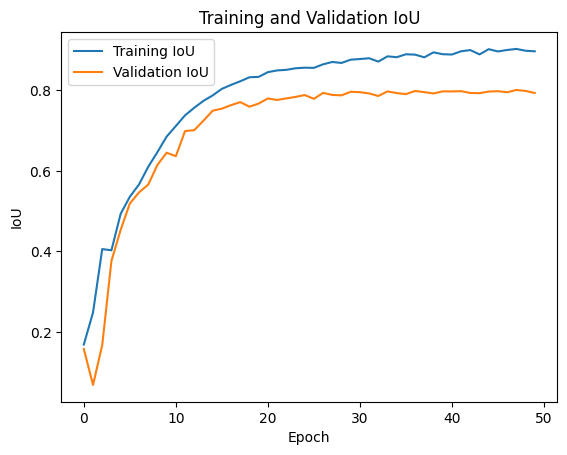

In [8]:
# Plotting training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation IoU
plt.plot(train_accs, label='Training IoU')
plt.plot(val_accs, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

### IOU and Dice Score

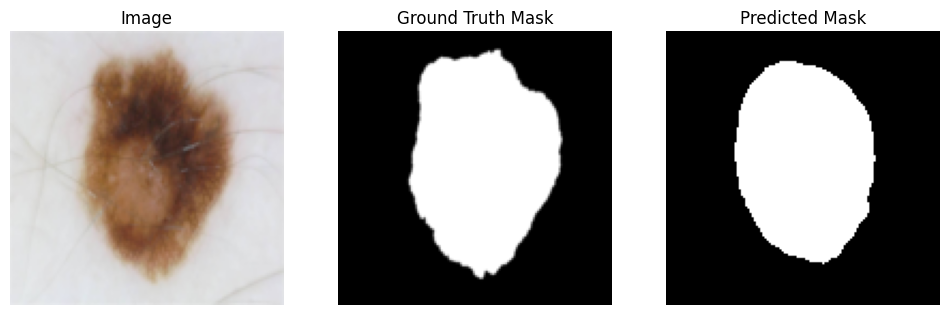

IoU: 0.8082848339609723, Dice Score: 0.9211649631668551


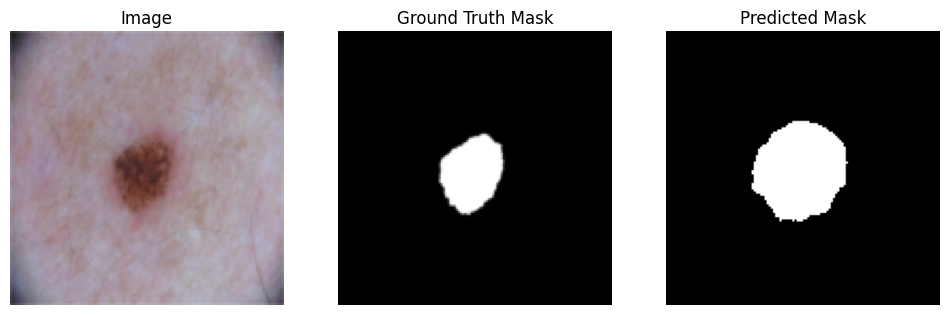

IoU: 0.5842911877394636, Dice Score: 0.7741540487733741


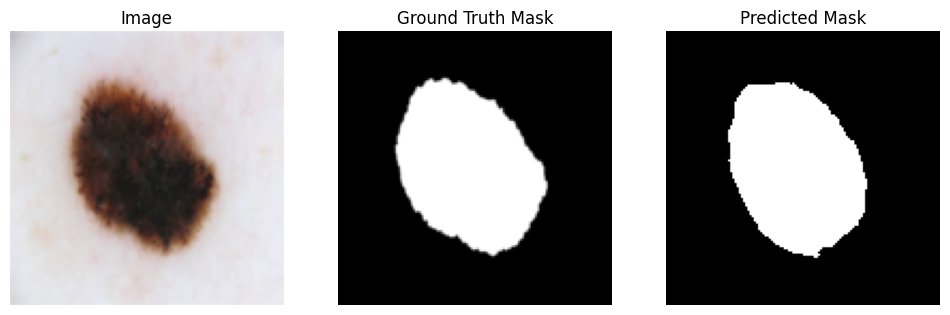

IoU: 0.8782448885825868, Dice Score: 0.96591098979641


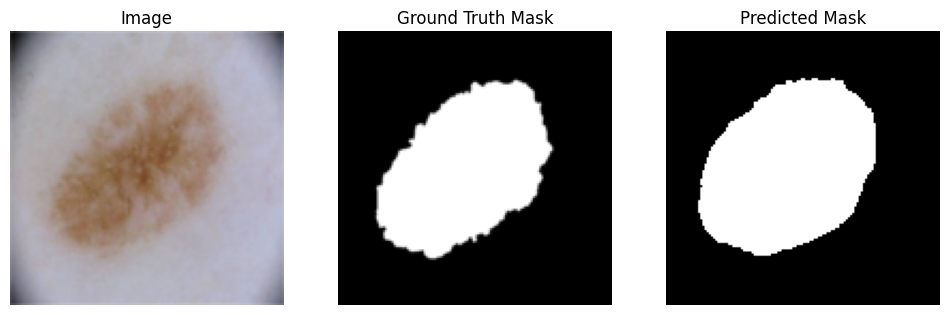

IoU: 0.8797348484848485, Dice Score: 0.9661998255490594


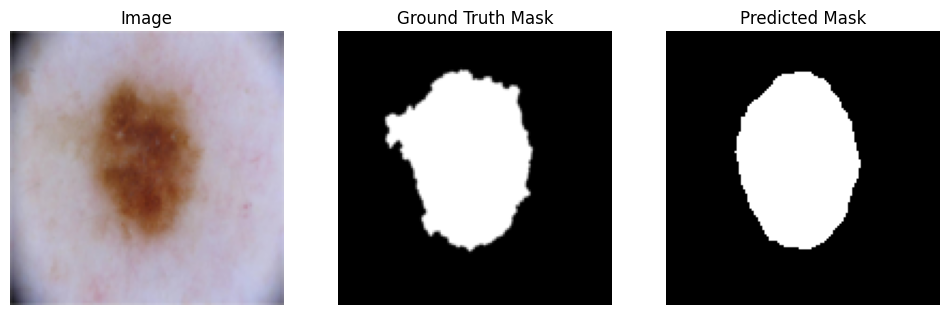

IoU: 0.8523377862595419, Dice Score: 0.957817692607641


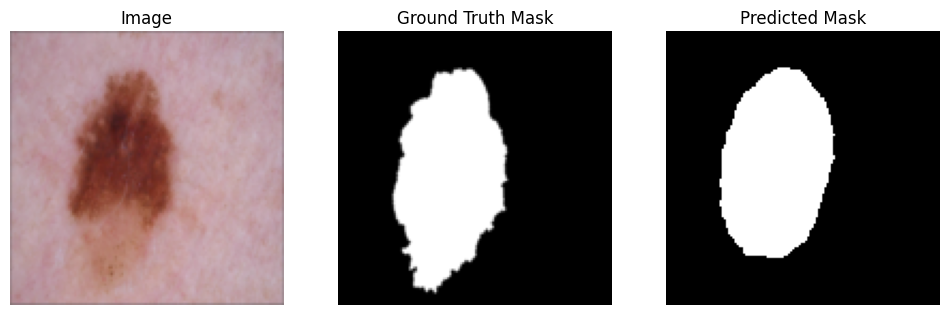

IoU: 0.8199859911277142, Dice Score: 0.937761642349116


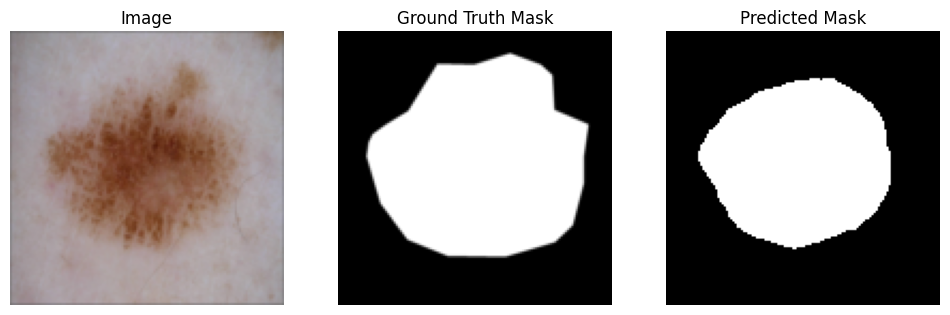

IoU: 0.6940395627277459, Dice Score: 0.8401076373141869


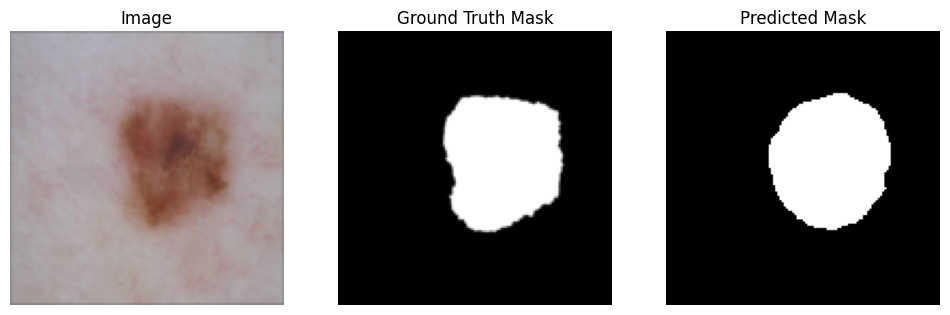

IoU: 0.8500315059861374, Dice Score: 0.9548898060467353


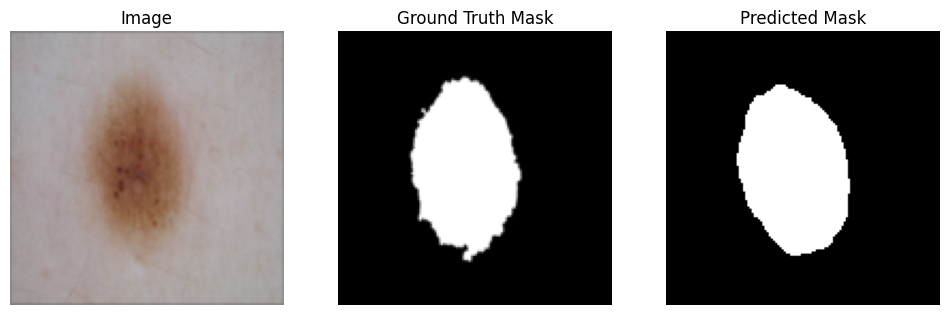

IoU: 0.8814252336448598, Dice Score: 0.9757943679275651


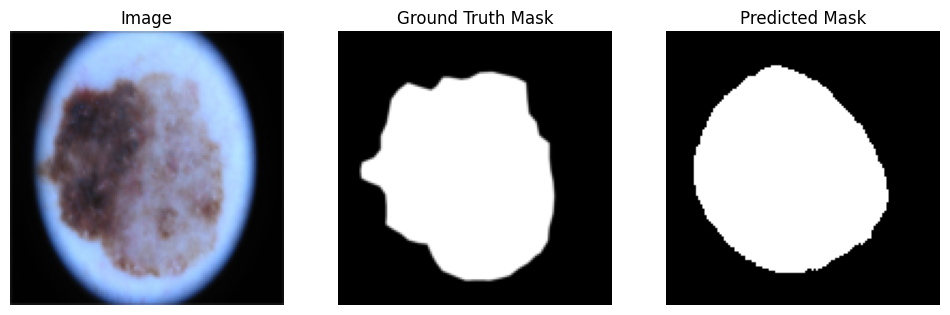

IoU: 0.8464677737123557, Dice Score: 0.9388591340898743
IoU: 0.8224574567868149, Dice Score: 0.9315736432436806
IoU: 0.8550493787830519, Dice Score: 0.964595440133591
IoU: 0.7767441860465116, Dice Score: 0.8928624709102626
IoU: 0.9221337725317962, Dice Score: 0.979108116318728
IoU: 0.8205645161290323, Dice Score: 0.9294847483238959
IoU: 0.8091417456844152, Dice Score: 0.918746825934679
IoU: 0.8608695652173913, Dice Score: 0.9568002324640907
IoU: 0.9110248185041364, Dice Score: 0.9820334048404676
IoU: 0.8099953938277291, Dice Score: 0.9181911923545596
IoU: 0.8506698187549251, Dice Score: 0.9587634521566059
IoU: 0.6198989506412748, Dice Score: 0.7934564666167035
IoU: 0.5901275651691625, Dice Score: 0.7659819632850506
IoU: 0.801715438950555, Dice Score: 0.9297952542833899
IoU: 0.7064471879286695, Dice Score: 0.8625256986404731
IoU: 0.407202216066482, Dice Score: 0.6102381859500213
IoU: 0.7739307535641547, Dice Score: 0.8955138008130783
IoU: 0.9318215284935945, Dice Score: 0.99082698569071

In [9]:
import torch
import matplotlib.pyplot as plt

# Load the saved model for testing
loaded_model = CustomSegmentationModel(1)  
loaded_model.load_state_dict(torch.load('trained_model_big_2.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Function to calculate IoU
def calculate_iou(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    union = torch.logical_or(gt_mask, predicted_mask).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

# Function to calculate Dice score
def calculate_dice(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    dice = 2 * intersection / (gt_mask.sum().item() + predicted_mask.sum().item())
    return dice

# Function to visualize image, ground truth mask, and predicted mask
def visualize_sample(image, gt_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(gt_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

iou_total = 0
dice_total = 0
num_samples = 0
num_visualized=0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, masks = data
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()

        for j in range(len(images)):
            if num_visualized < 10:  # Visualize only 10 images
                visualize_sample(images[j].cpu(), masks[j].cpu(), predicted_masks[j].cpu())
                num_visualized += 1
            iou = calculate_iou(masks[j], predicted_masks[j])
            dice = calculate_dice(masks[j], predicted_masks[j])
            iou_total += iou
            dice_total += dice
            num_samples += 1

            print(f"IoU: {iou}, Dice Score: {dice}")

# Calculate average IoU and Dice score
avg_iou = iou_total / num_samples
avg_dice = dice_total / num_samples

print(f"Average IoU: {avg_iou}, Average Dice Score: {avg_dice}")


## Model 1 without fine tuning
## (With Features taken from multiple encoder layers)

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.encoder = models.mobilenet_v2(pretrained=True).features

        # Freeze encoder weights
        for param in self.encoder.parameters():
            param.requires_grad = False

        

        # Upsampling layers
        self.conv1 = nn.Conv2d(2560, 1280, kernel_size=1, stride=1, padding=0)
        self.norm1 = nn.BatchNorm2d(1280)
        self.relu1 = nn.ReLU6(inplace=True)
        self.ir_block1 = InvertedResidual(1280, 1280)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv2 = nn.Conv2d(1344, 640, kernel_size=1, stride=1, padding=0)  # Added skip connection
        self.norm2 = nn.BatchNorm2d(640)
        self.relu2 = nn.ReLU6(inplace=True)
        self.ir_block2 = InvertedResidual(640, 640)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv3 = nn.Conv2d(672, 960, kernel_size=1, stride=1, padding=0)  # Added skip connection
        self.norm3 = nn.BatchNorm2d(960)
        self.relu3 = nn.ReLU6(inplace=True)
        self.ir_block3 = InvertedResidual(960, 960)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv4 = nn.Conv2d(984, 320, kernel_size=1, stride=1, padding=0)  # Added skip connection
        self.norm4 = nn.BatchNorm2d(320)
        self.relu4 = nn.ReLU6(inplace=True)
        self.ir_block4 = InvertedResidual(320, 320)

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv5 = nn.Conv2d(352, 160, kernel_size=1, stride=1, padding=0)
        self.norm5 = nn.BatchNorm2d(160)
        self.relu5 = nn.ReLU6(inplace=True)
        self.ir_block5 = InvertedResidual(160, 160)

        self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv6 = nn.Conv2d(160, 160, kernel_size=1, stride=1, padding=0)
        self.norm6 = nn.BatchNorm2d(160)
        self.relu6 = nn.ReLU6(inplace=True)
        self.ir_block6 = InvertedResidual(160, 160)

        # self.up6 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv7 = nn.Conv2d(160, 32, kernel_size=1, stride=1, padding=0)
        self.norm7 = nn.BatchNorm2d(32)
        self.relu7 = nn.ReLU6(inplace=True)
        self.ir_block7 = InvertedResidual(32, 32)

        # self.up7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv8 = nn.Conv2d(32, 24, kernel_size=1, stride=1, padding=0)
        self.norm8 = nn.BatchNorm2d(24)
        self.relu8 = nn.ReLU6(inplace=True)
        self.ir_block8 = InvertedResidual(24, 24)


        self.conv9 = nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0)
        self.norm9 = nn.BatchNorm2d(16)
        self.relu9 = nn.ReLU6(inplace=True)
        self.ir_block9 = InvertedResidual(16, 16)

        self.conv10 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.norm10 = nn.BatchNorm2d(16)
        self.relu10 = nn.ReLU6(inplace=True)

        self.conv11 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        # Forward pass through the encoder
        features = []
        for i, layer in enumerate(self.encoder):
            # print(i)
            # print(f"Layer {layer} size: {x.size()}")  # Print feature map size
            x = layer(x)
            if i in {0, 2, 4, 5, 7, 14, 18}:  # Layers to extract features from
                features.append(x)
       
        
        features = features[::-1]
        
        x = torch.cat([x, features[0]], dim=1)  
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.ir_block1(x)
        x = self.up1(x)

        x = torch.cat([x, features[2]], dim=1)
        x = self.relu2(self.norm2(self.conv2(x)))
        x = self.ir_block2(x)
        x = self.up2(x)
        
        x = torch.cat([x, features[4]], dim=1) 
        x = self.relu3(self.norm3(self.conv3(x)))
        x = self.ir_block3(x)
        x = self.up3(x)

       
        x = torch.cat([x, features[5]], dim=1) 
        x = self.relu4(self.norm4(self.conv4(x)))
        x = self.ir_block4(x)
        x = self.up4(x)

        x = torch.cat([x, features[6]], dim=1)
        x = self.relu5(self.norm5(self.conv5(x)))
        x = self.ir_block5(x)
        x = self.up5(x)

        x = self.relu6(self.norm6(self.conv6(x)))
        x = self.ir_block6(x)
        # x = self.up6(x)

        x = self.relu7(self.norm7(self.conv7(x)))
        x = self.ir_block7(x)
        # x = self.up7(x)

        x = self.relu8(self.norm8(self.conv8(x)))
        x = self.ir_block8(x)
        # x = self.up8(x)

        x = self.relu9(self.norm9(self.conv9(x)))
        x = self.ir_block9(x)
        # x = self.up9(x)

        x = self.relu10(self.norm10(self.conv10(x)))
        x = self.conv11(x)
        return x

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(InvertedResidual, self).__init__()

        self.stride = stride

        if stride == 1:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, dilation=2)
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU6(inplace=True)

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.norm2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU6(inplace=True)

    def forward(self, x):
        residual = x

        out = self.relu1(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))

        if self.stride == 1:
            out += residual

        out = self.relu2(out)

        return out

# Define the full model
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        # self.encoder = models.mobilenet_v2(pretrained=True).features

        # for param in self.encoder.parameters():
        #     param.requires_grad = True
        self.decoder = Decoder()

    def forward(self, x):
        # print(x.shape)
        x = self.decoder(x)
        return x
num_classes = 1 
model = SegmentationModel(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

### Training Loop

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_iou(outputs, targets, threshold=0.5):
    # Convert outputs and targets to binary masks
    outputs = (outputs > threshold).long()
    targets = (targets > 0.5).long()
    
    intersection = (outputs & targets).float().sum((1, 2))
    union = (outputs | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add epsilon to avoid division by zero
    return iou.mean().item()

# Define Dice loss function
def dice_loss(input, target, smooth=1):
    input = torch.sigmoid(input)
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Define combined loss function
def combined_loss(input, target, alpha=0.5):
    bce_loss = nn.BCEWithLogitsLoss()(input, target)
    dice = dice_loss(input, target)
    combined = alpha * bce_loss + (1 - alpha) * dice
    return combined

# Define loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define loss function and optimizer with SGD and momentum
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# Training loop
num_epochs = 50

# Initialize variables for best loss and best model weights
best_loss = float('inf')
best_weights = None

# Lists to store training and validation losses
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_iou_train = 0.0
    total_batches_train = 0
    
    for i, data in enumerate(tqdm(train_dataloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Calculate combined loss
        loss = combined_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate IoU for training accuracy
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()
        total_iou_train += calculate_iou(predicted_masks, labels)
        total_batches_train += 1
    
    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = total_iou_train / total_batches_train
    train_accs.append(train_acc)
    
    # Check if current epoch has the best validation loss
    if loss < best_loss:
        best_loss = loss
        best_weights = model.state_dict()

    # Validation
    model.eval()
    val_loss = 0.0
    total_iou_val = 0.0
    total_batches_val = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # Calculate combined loss for validation
            loss = combined_loss(outputs, labels)
            val_loss += loss.item()
            
            # Calculate IoU for validation accuracy
            predicted_masks = torch.sigmoid(outputs) > 0.5
            predicted_masks = predicted_masks.bool()
            total_iou_val += calculate_iou(predicted_masks, labels)
            total_batches_val += 1
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = total_iou_val / total_batches_val
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Training IoU: {train_acc:.4f}, '
          f'Validation IoU: {val_acc:.4f}')
    
torch.save(model.state_dict(), 'trained_model_big_3.pth')

100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [1/50], Training Loss: 0.6575, Validation Loss: 0.6596, Training IoU: 0.0822, Validation IoU: 0.4702


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [2/50], Training Loss: 0.6365, Validation Loss: 0.6492, Training IoU: 0.1398, Validation IoU: 0.4634


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


Epoch [3/50], Training Loss: 0.6079, Validation Loss: 0.6350, Training IoU: 0.2893, Validation IoU: 0.4574


100%|██████████| 13/13 [00:50<00:00,  3.90s/it]


Epoch [4/50], Training Loss: 0.5361, Validation Loss: 0.5571, Training IoU: 0.4203, Validation IoU: 0.4593


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


Epoch [5/50], Training Loss: 0.4378, Validation Loss: 0.4810, Training IoU: 0.5678, Validation IoU: 0.5182


100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


Epoch [6/50], Training Loss: 0.3249, Validation Loss: 0.3857, Training IoU: 0.6855, Validation IoU: 0.6232


100%|██████████| 13/13 [00:50<00:00,  3.86s/it]


Epoch [7/50], Training Loss: 0.2337, Validation Loss: 0.3015, Training IoU: 0.7528, Validation IoU: 0.6979


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [8/50], Training Loss: 0.1835, Validation Loss: 0.2686, Training IoU: 0.8013, Validation IoU: 0.7308


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [9/50], Training Loss: 0.1566, Validation Loss: 0.2593, Training IoU: 0.8278, Validation IoU: 0.7431


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [10/50], Training Loss: 0.1366, Validation Loss: 0.2627, Training IoU: 0.8432, Validation IoU: 0.7656


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [11/50], Training Loss: 0.1229, Validation Loss: 0.2375, Training IoU: 0.8543, Validation IoU: 0.7694


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [12/50], Training Loss: 0.1260, Validation Loss: 0.2591, Training IoU: 0.8583, Validation IoU: 0.7776


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [13/50], Training Loss: 0.1088, Validation Loss: 0.2362, Training IoU: 0.8699, Validation IoU: 0.7742


100%|██████████| 13/13 [00:48<00:00,  3.70s/it]


Epoch [14/50], Training Loss: 0.1113, Validation Loss: 0.2305, Training IoU: 0.8677, Validation IoU: 0.7861


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [15/50], Training Loss: 0.1016, Validation Loss: 0.2254, Training IoU: 0.8774, Validation IoU: 0.7840


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [16/50], Training Loss: 0.0918, Validation Loss: 0.2368, Training IoU: 0.8889, Validation IoU: 0.7904


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [17/50], Training Loss: 0.0880, Validation Loss: 0.2202, Training IoU: 0.8907, Validation IoU: 0.7966


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [18/50], Training Loss: 0.0895, Validation Loss: 0.2288, Training IoU: 0.8898, Validation IoU: 0.7931


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [19/50], Training Loss: 0.0811, Validation Loss: 0.2296, Training IoU: 0.8999, Validation IoU: 0.7976


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [20/50], Training Loss: 0.0888, Validation Loss: 0.2312, Training IoU: 0.8894, Validation IoU: 0.7920


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [21/50], Training Loss: 0.0806, Validation Loss: 0.2436, Training IoU: 0.8998, Validation IoU: 0.7963


100%|██████████| 13/13 [00:48<00:00,  3.77s/it]


Epoch [22/50], Training Loss: 0.0763, Validation Loss: 0.2332, Training IoU: 0.9030, Validation IoU: 0.8023


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [23/50], Training Loss: 0.0760, Validation Loss: 0.2217, Training IoU: 0.9046, Validation IoU: 0.8096


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [24/50], Training Loss: 0.0759, Validation Loss: 0.2248, Training IoU: 0.9035, Validation IoU: 0.8075


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [25/50], Training Loss: 0.0758, Validation Loss: 0.2151, Training IoU: 0.9030, Validation IoU: 0.8060


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [26/50], Training Loss: 0.0690, Validation Loss: 0.2239, Training IoU: 0.9110, Validation IoU: 0.8104


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [27/50], Training Loss: 0.0717, Validation Loss: 0.2192, Training IoU: 0.9083, Validation IoU: 0.8103


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [28/50], Training Loss: 0.0717, Validation Loss: 0.2191, Training IoU: 0.9097, Validation IoU: 0.8054


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [29/50], Training Loss: 0.0704, Validation Loss: 0.2452, Training IoU: 0.9101, Validation IoU: 0.8075


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [30/50], Training Loss: 0.0712, Validation Loss: 0.2240, Training IoU: 0.9089, Validation IoU: 0.8075


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [31/50], Training Loss: 0.0665, Validation Loss: 0.2281, Training IoU: 0.9133, Validation IoU: 0.8114


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [32/50], Training Loss: 0.0678, Validation Loss: 0.2301, Training IoU: 0.9134, Validation IoU: 0.8141


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [33/50], Training Loss: 0.0695, Validation Loss: 0.2243, Training IoU: 0.9104, Validation IoU: 0.8111


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [34/50], Training Loss: 0.0640, Validation Loss: 0.2203, Training IoU: 0.9139, Validation IoU: 0.8112


100%|██████████| 13/13 [00:48<00:00,  3.77s/it]


Epoch [35/50], Training Loss: 0.0668, Validation Loss: 0.2204, Training IoU: 0.9130, Validation IoU: 0.8145


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [36/50], Training Loss: 0.0708, Validation Loss: 0.2130, Training IoU: 0.9082, Validation IoU: 0.8129


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [37/50], Training Loss: 0.0602, Validation Loss: 0.2187, Training IoU: 0.9196, Validation IoU: 0.8151


100%|██████████| 13/13 [00:48<00:00,  3.70s/it]


Epoch [38/50], Training Loss: 0.0665, Validation Loss: 0.2224, Training IoU: 0.9130, Validation IoU: 0.8126


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [39/50], Training Loss: 0.0647, Validation Loss: 0.2235, Training IoU: 0.9150, Validation IoU: 0.8055


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [40/50], Training Loss: 0.0578, Validation Loss: 0.2209, Training IoU: 0.9223, Validation IoU: 0.8129


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [41/50], Training Loss: 0.0597, Validation Loss: 0.2127, Training IoU: 0.9210, Validation IoU: 0.8097


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [42/50], Training Loss: 0.0639, Validation Loss: 0.2132, Training IoU: 0.9149, Validation IoU: 0.8058


100%|██████████| 13/13 [00:48<00:00,  3.71s/it]


Epoch [43/50], Training Loss: 0.0588, Validation Loss: 0.2292, Training IoU: 0.9226, Validation IoU: 0.8112


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [44/50], Training Loss: 0.0630, Validation Loss: 0.2178, Training IoU: 0.9173, Validation IoU: 0.8101


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [45/50], Training Loss: 0.0558, Validation Loss: 0.2157, Training IoU: 0.9235, Validation IoU: 0.8117


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


Epoch [46/50], Training Loss: 0.0528, Validation Loss: 0.2222, Training IoU: 0.9286, Validation IoU: 0.8150


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Epoch [47/50], Training Loss: 0.0557, Validation Loss: 0.2311, Training IoU: 0.9246, Validation IoU: 0.8109


100%|██████████| 13/13 [00:50<00:00,  3.89s/it]


Epoch [48/50], Training Loss: 0.0553, Validation Loss: 0.2299, Training IoU: 0.9247, Validation IoU: 0.8110


100%|██████████| 13/13 [00:50<00:00,  3.90s/it]


Epoch [49/50], Training Loss: 0.0525, Validation Loss: 0.2214, Training IoU: 0.9274, Validation IoU: 0.8144


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [50/50], Training Loss: 0.0553, Validation Loss: 0.2121, Training IoU: 0.9261, Validation IoU: 0.8094


### Curves

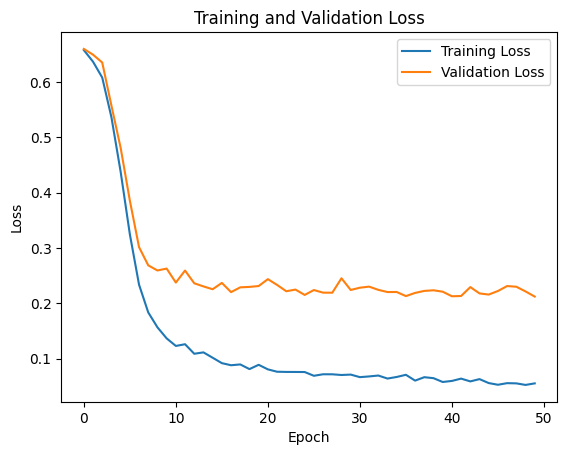

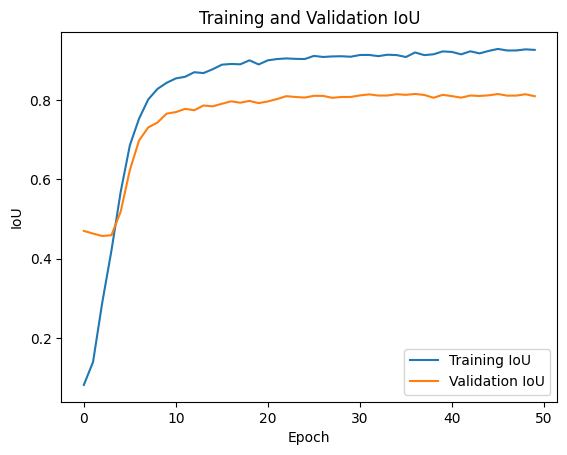

In [12]:
# Plotting training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation IoU
plt.plot(train_accs, label='Training IoU')
plt.plot(val_accs, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

### IOU and Dice Score

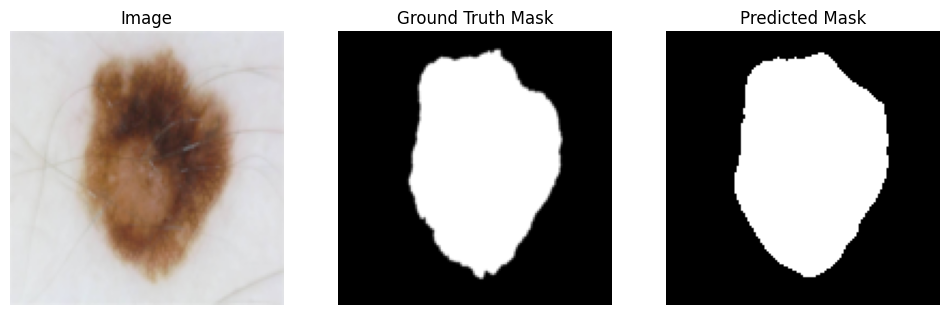

IoU: 0.953280659567159, Dice Score: 1.0035952804957158


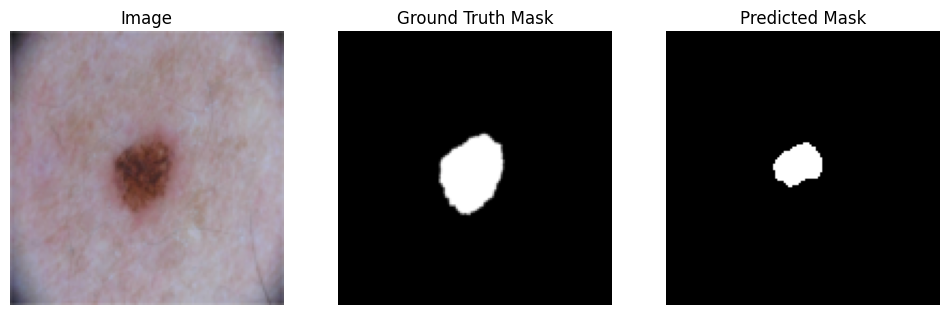

IoU: 0.3639344262295082, Dice Score: 0.5889267939048964


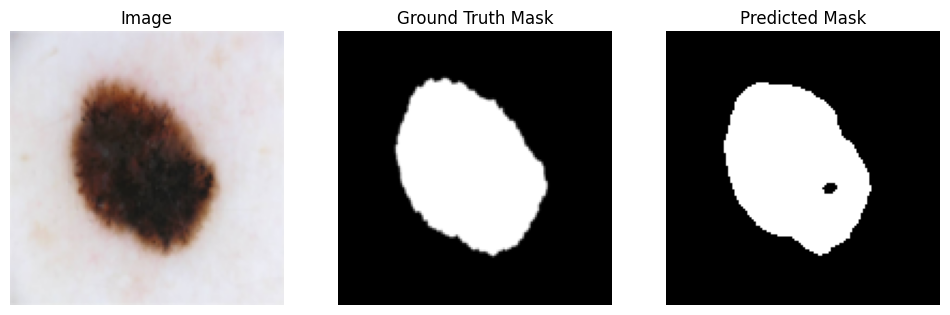

IoU: 0.9017690875232774, Dice Score: 0.9795390052161941


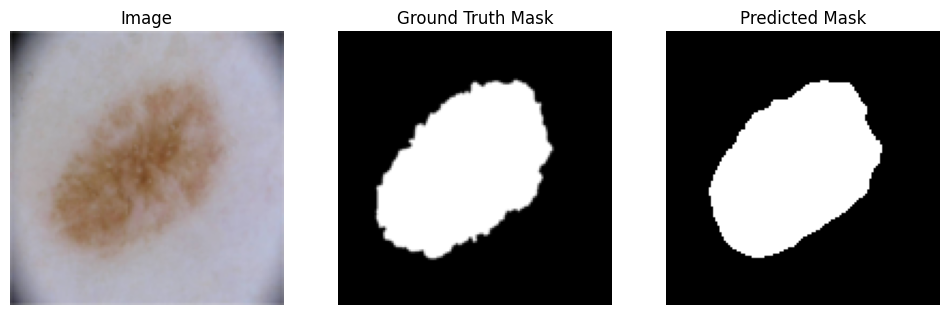

IoU: 0.9117405582922824, Dice Score: 0.9866738741208866


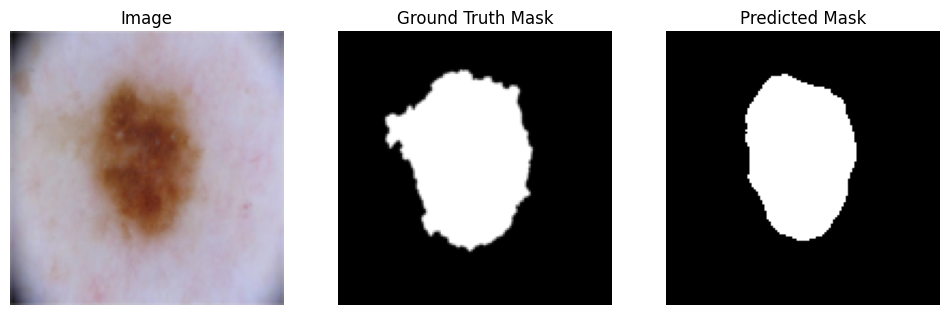

IoU: 0.7341650671785028, Dice Score: 0.8839191754894548


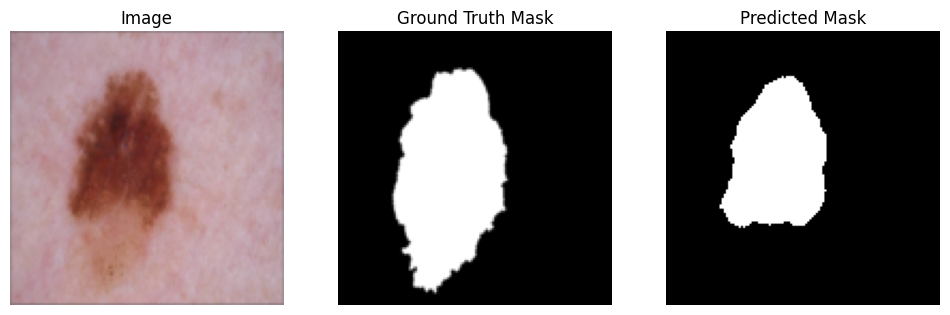

IoU: 0.6218103033220992, Dice Score: 0.8031496314040654


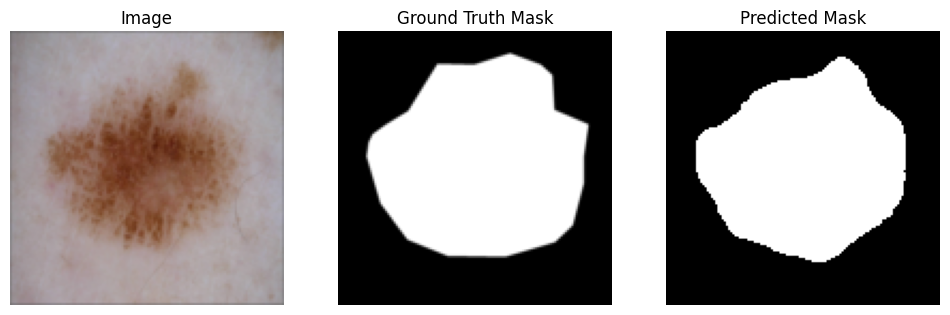

IoU: 0.8463737977644918, Dice Score: 0.9379911651462713


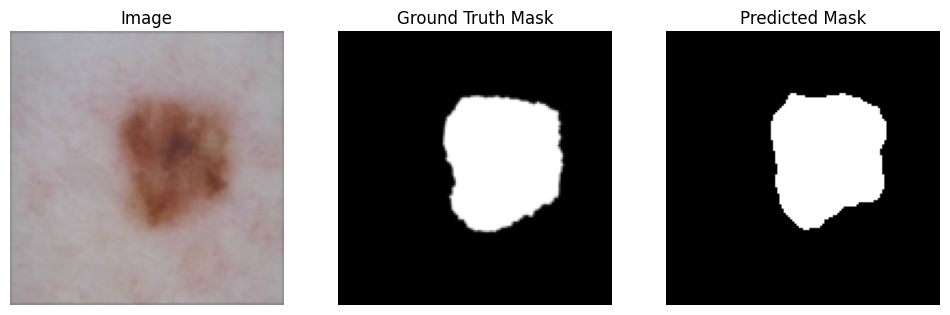

IoU: 0.8558616271620756, Dice Score: 0.958923854590171


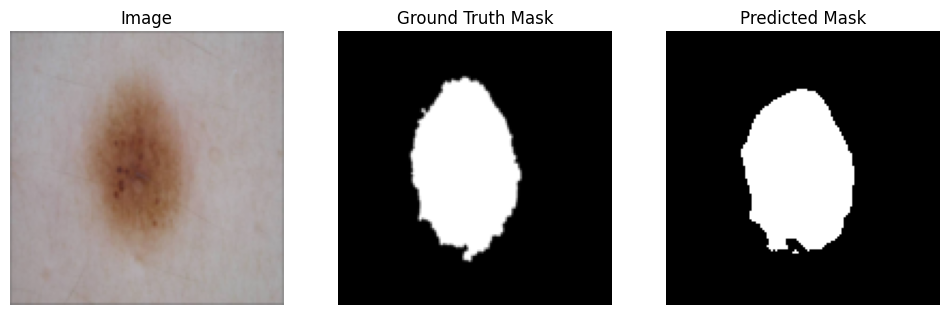

IoU: 0.823342939481268, Dice Score: 0.9412377882021297


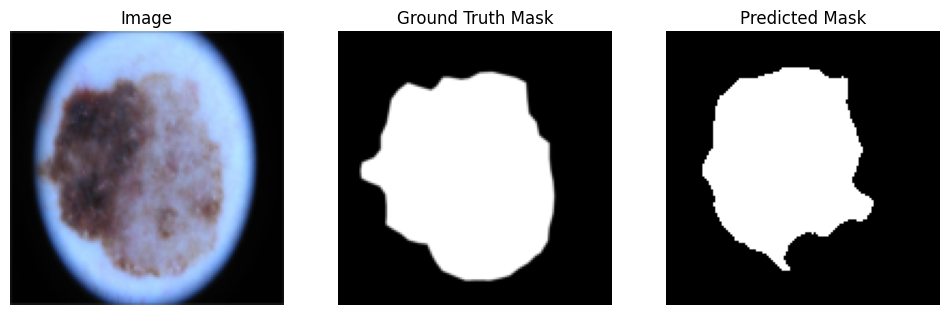

IoU: 0.736780430643035, Dice Score: 0.8710391227917383
IoU: 0.6909361069836553, Dice Score: 0.8458248805508287
IoU: 0.4034552845528455, Dice Score: 0.6131230977902947
IoU: 0.887477564545078, Dice Score: 0.9632712757336427
IoU: 0.8906816879893068, Dice Score: 0.9626416795634982
IoU: 0.8574908647990256, Dice Score: 0.9510842377293213
IoU: 0.802268101192207, Dice Score: 0.9194136932212906
IoU: 0.9065017261219793, Dice Score: 0.9856097043925988
IoU: 0.9251236568309739, Dice Score: 0.9900120062334556
IoU: 0.8485130111524164, Dice Score: 0.9415144880366682
IoU: 0.8457648546144121, Dice Score: 0.9587462583379032
IoU: 0.8235294117647058, Dice Score: 0.9483859894923219
IoU: 0.7127222982216143, Dice Score: 0.8736073490541449
IoU: 0.797360248447205, Dice Score: 0.9281639128319468
IoU: 0.4425287356321839, Dice Score: 0.652403611850962
IoU: 0.7703549060542797, Dice Score: 0.9592671756887959
IoU: 0.4494004094764551, Dice Score: 0.6403118994059301
IoU: 0.8612136424036616, Dice Score: 0.95153668082835

In [17]:
import torch
import matplotlib.pyplot as plt

# Load the saved model for testing
loaded_model = SegmentationModel(1)  
loaded_model.load_state_dict(torch.load('trained_model_big_3.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Function to calculate IoU
def calculate_iou(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    union = torch.logical_or(gt_mask, predicted_mask).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

# Function to calculate Dice score
def calculate_dice(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    dice = 2 * intersection / (gt_mask.sum().item() + predicted_mask.sum().item())
    return dice

# Function to visualize image, ground truth mask, and predicted mask
def visualize_sample(image, gt_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(gt_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

iou_total = 0
dice_total = 0
num_samples = 0
num_visualized=0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, masks = data
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()

        for j in range(len(images)):
            if num_visualized < 10:  # Visualize only 10 images
                visualize_sample(images[j].cpu(), masks[j].cpu(), predicted_masks[j].cpu())
                num_visualized+=1
            iou = calculate_iou(masks[j], predicted_masks[j])
            dice = calculate_dice(masks[j], predicted_masks[j])
            iou_total += iou
            dice_total += dice
            num_samples += 1

            print(f"IoU: {iou}, Dice Score: {dice}")

# Calculate average IoU and Dice score
avg_iou = iou_total / num_samples
avg_dice = dice_total / num_samples

print(f"Average IoU: {avg_iou}, Average Dice Score: {avg_dice}")


## Model 1 with Fine Tuning of Encoder Weights

In [20]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.encoder = models.mobilenet_v2(pretrained=True).features

        # Freeze encoder weights
        for param in self.encoder.parameters():
            param.requires_grad = True

        

        # Upsampling layers
        self.conv1 = nn.Conv2d(2560, 1280, kernel_size=1, stride=1, padding=0)
        self.norm1 = nn.BatchNorm2d(1280)
        self.relu1 = nn.ReLU6(inplace=True)
        self.ir_block1 = InvertedResidual(1280, 1280)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv2 = nn.Conv2d(1344, 640, kernel_size=1, stride=1, padding=0)  # Added skip connection
        self.norm2 = nn.BatchNorm2d(640)
        self.relu2 = nn.ReLU6(inplace=True)
        self.ir_block2 = InvertedResidual(640, 640)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv3 = nn.Conv2d(672, 960, kernel_size=1, stride=1, padding=0)  # Added skip connection
        self.norm3 = nn.BatchNorm2d(960)
        self.relu3 = nn.ReLU6(inplace=True)
        self.ir_block3 = InvertedResidual(960, 960)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv4 = nn.Conv2d(984, 320, kernel_size=1, stride=1, padding=0)  # Added skip connection
        self.norm4 = nn.BatchNorm2d(320)
        self.relu4 = nn.ReLU6(inplace=True)
        self.ir_block4 = InvertedResidual(320, 320)

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv5 = nn.Conv2d(352, 160, kernel_size=1, stride=1, padding=0)
        self.norm5 = nn.BatchNorm2d(160)
        self.relu5 = nn.ReLU6(inplace=True)
        self.ir_block5 = InvertedResidual(160, 160)

        self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv6 = nn.Conv2d(160, 160, kernel_size=1, stride=1, padding=0)
        self.norm6 = nn.BatchNorm2d(160)
        self.relu6 = nn.ReLU6(inplace=True)
        self.ir_block6 = InvertedResidual(160, 160)

        # self.up6 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv7 = nn.Conv2d(160, 32, kernel_size=1, stride=1, padding=0)
        self.norm7 = nn.BatchNorm2d(32)
        self.relu7 = nn.ReLU6(inplace=True)
        self.ir_block7 = InvertedResidual(32, 32)

        # self.up7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv8 = nn.Conv2d(32, 24, kernel_size=1, stride=1, padding=0)
        self.norm8 = nn.BatchNorm2d(24)
        self.relu8 = nn.ReLU6(inplace=True)
        self.ir_block8 = InvertedResidual(24, 24)


        self.conv9 = nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0)
        self.norm9 = nn.BatchNorm2d(16)
        self.relu9 = nn.ReLU6(inplace=True)
        self.ir_block9 = InvertedResidual(16, 16)

        self.conv10 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.norm10 = nn.BatchNorm2d(16)
        self.relu10 = nn.ReLU6(inplace=True)

        self.conv11 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        # Forward pass through the encoder
        features = []
        for i, layer in enumerate(self.encoder):
            # print(i)
            # print(f"Layer {layer} size: {x.size()}")  # Print feature map size
            x = layer(x)
            if i in {0, 2, 4, 5, 7, 14, 18}:  # Layers to extract features from
                features.append(x)
       
        
        features = features[::-1]
        
        x = torch.cat([x, features[0]], dim=1)  
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.ir_block1(x)
        x = self.up1(x)

        x = torch.cat([x, features[2]], dim=1)
        x = self.relu2(self.norm2(self.conv2(x)))
        x = self.ir_block2(x)
        x = self.up2(x)
        
        x = torch.cat([x, features[4]], dim=1) 
        x = self.relu3(self.norm3(self.conv3(x)))
        x = self.ir_block3(x)
        x = self.up3(x)

       
        x = torch.cat([x, features[5]], dim=1) 
        x = self.relu4(self.norm4(self.conv4(x)))
        x = self.ir_block4(x)
        x = self.up4(x)

        x = torch.cat([x, features[6]], dim=1)
        x = self.relu5(self.norm5(self.conv5(x)))
        x = self.ir_block5(x)
        x = self.up5(x)

        x = self.relu6(self.norm6(self.conv6(x)))
        x = self.ir_block6(x)
        # x = self.up6(x)

        x = self.relu7(self.norm7(self.conv7(x)))
        x = self.ir_block7(x)
        # x = self.up7(x)

        x = self.relu8(self.norm8(self.conv8(x)))
        x = self.ir_block8(x)
        # x = self.up8(x)

        x = self.relu9(self.norm9(self.conv9(x)))
        x = self.ir_block9(x)
        # x = self.up9(x)

        x = self.relu10(self.norm10(self.conv10(x)))
        x = self.conv11(x)
        return x

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(InvertedResidual, self).__init__()

        self.stride = stride

        if stride == 1:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, dilation=2)
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU6(inplace=True)

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.norm2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU6(inplace=True)

    def forward(self, x):
        residual = x

        out = self.relu1(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))

        if self.stride == 1:
            out += residual

        out = self.relu2(out)

        return out

# Define the full model
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        # self.encoder = models.mobilenet_v2(pretrained=True).features

        # for param in self.encoder.parameters():
        #     param.requires_grad = True
        self.decoder = Decoder()

    def forward(self, x):
        # print(x.shape)
        x = self.decoder(x)
        return x
num_classes = 1 
model = SegmentationModel(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

### Training Loop

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_iou(outputs, targets, threshold=0.5):
    # Convert outputs and targets to binary masks
    outputs = (outputs > threshold).long()
    targets = (targets > 0.5).long()
    
    intersection = (outputs & targets).float().sum((1, 2))
    union = (outputs | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add epsilon to avoid division by zero
    return iou.mean().item()

# Define Dice loss function
def dice_loss(input, target, smooth=1):
    input = torch.sigmoid(input)
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Define combined loss function
def combined_loss(input, target, alpha=0.5):
    bce_loss = nn.BCEWithLogitsLoss()(input, target)
    dice = dice_loss(input, target)
    combined = alpha * bce_loss + (1 - alpha) * dice
    return combined

# Define loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define loss function and optimizer with SGD and momentum
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# Training loop
num_epochs = 50

# Initialize variables for best loss and best model weights
best_loss = float('inf')
best_weights = None

# Lists to store training and validation losses
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_iou_train = 0.0
    total_batches_train = 0
    
    for i, data in enumerate(tqdm(train_dataloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Calculate combined loss
        loss = combined_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate IoU for training accuracy
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()
        total_iou_train += calculate_iou(predicted_masks, labels)
        total_batches_train += 1
    
    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = total_iou_train / total_batches_train
    train_accs.append(train_acc)
    
    # Check if current epoch has the best validation loss
    if loss < best_loss:
        best_loss = loss
        best_weights = model.state_dict()

    # Validation
    model.eval()
    val_loss = 0.0
    total_iou_val = 0.0
    total_batches_val = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # Calculate combined loss for validation
            loss = combined_loss(outputs, labels)
            val_loss += loss.item()
            
            # Calculate IoU for validation accuracy
            predicted_masks = torch.sigmoid(outputs) > 0.5
            predicted_masks = predicted_masks.bool()
            total_iou_val += calculate_iou(predicted_masks, labels)
            total_batches_val += 1
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = total_iou_val / total_batches_val
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Training IoU: {train_acc:.4f}, '
          f'Validation IoU: {val_acc:.4f}')
    
torch.save(model.state_dict(), 'trained_model_big_4.pth')

100%|██████████| 13/13 [00:51<00:00,  3.95s/it]


Epoch [1/50], Training Loss: 0.6907, Validation Loss: 0.6581, Training IoU: 0.1763, Validation IoU: 0.4390


100%|██████████| 13/13 [00:50<00:00,  3.91s/it]


Epoch [2/50], Training Loss: 0.6329, Validation Loss: 0.6519, Training IoU: 0.1773, Validation IoU: 0.1961


100%|██████████| 13/13 [00:53<00:00,  4.14s/it]


Epoch [3/50], Training Loss: 0.5848, Validation Loss: 0.6447, Training IoU: 0.2700, Validation IoU: 0.2737


100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


Epoch [4/50], Training Loss: 0.4878, Validation Loss: 0.5040, Training IoU: 0.4291, Validation IoU: 0.4000


100%|██████████| 13/13 [00:50<00:00,  3.89s/it]


Epoch [5/50], Training Loss: 0.3627, Validation Loss: 0.4164, Training IoU: 0.5879, Validation IoU: 0.4946


100%|██████████| 13/13 [00:50<00:00,  3.86s/it]


Epoch [6/50], Training Loss: 0.2612, Validation Loss: 0.3216, Training IoU: 0.7072, Validation IoU: 0.6357


100%|██████████| 13/13 [00:53<00:00,  4.08s/it]


Epoch [7/50], Training Loss: 0.2013, Validation Loss: 0.2348, Training IoU: 0.7733, Validation IoU: 0.7340


100%|██████████| 13/13 [00:55<00:00,  4.30s/it]


Epoch [8/50], Training Loss: 0.1639, Validation Loss: 0.2321, Training IoU: 0.8125, Validation IoU: 0.7607


100%|██████████| 13/13 [00:52<00:00,  4.08s/it]


Epoch [9/50], Training Loss: 0.1440, Validation Loss: 0.2122, Training IoU: 0.8349, Validation IoU: 0.7742


100%|██████████| 13/13 [00:53<00:00,  4.15s/it]


Epoch [10/50], Training Loss: 0.1322, Validation Loss: 0.1949, Training IoU: 0.8487, Validation IoU: 0.7935


100%|██████████| 13/13 [00:52<00:00,  4.06s/it]


Epoch [11/50], Training Loss: 0.1168, Validation Loss: 0.1806, Training IoU: 0.8622, Validation IoU: 0.8103


100%|██████████| 13/13 [00:51<00:00,  3.97s/it]


Epoch [12/50], Training Loss: 0.1059, Validation Loss: 0.1907, Training IoU: 0.8737, Validation IoU: 0.8023


100%|██████████| 13/13 [00:51<00:00,  3.99s/it]


Epoch [13/50], Training Loss: 0.1019, Validation Loss: 0.1796, Training IoU: 0.8780, Validation IoU: 0.8105


100%|██████████| 13/13 [00:54<00:00,  4.18s/it]


Epoch [14/50], Training Loss: 0.0923, Validation Loss: 0.1682, Training IoU: 0.8874, Validation IoU: 0.8194


100%|██████████| 13/13 [00:51<00:00,  3.97s/it]


Epoch [15/50], Training Loss: 0.0847, Validation Loss: 0.1672, Training IoU: 0.8942, Validation IoU: 0.8239


100%|██████████| 13/13 [00:50<00:00,  3.90s/it]


Epoch [16/50], Training Loss: 0.0781, Validation Loss: 0.1808, Training IoU: 0.9014, Validation IoU: 0.8200


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch [17/50], Training Loss: 0.0786, Validation Loss: 0.1840, Training IoU: 0.9019, Validation IoU: 0.8265


100%|██████████| 13/13 [00:52<00:00,  4.01s/it]


Epoch [18/50], Training Loss: 0.0762, Validation Loss: 0.1849, Training IoU: 0.9032, Validation IoU: 0.8182


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch [19/50], Training Loss: 0.0741, Validation Loss: 0.1642, Training IoU: 0.9065, Validation IoU: 0.8335


100%|██████████| 13/13 [00:51<00:00,  3.95s/it]


Epoch [20/50], Training Loss: 0.0712, Validation Loss: 0.1591, Training IoU: 0.9107, Validation IoU: 0.8386


100%|██████████| 13/13 [00:53<00:00,  4.09s/it]


Epoch [21/50], Training Loss: 0.0708, Validation Loss: 0.1743, Training IoU: 0.9092, Validation IoU: 0.8222


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch [22/50], Training Loss: 0.0650, Validation Loss: 0.1626, Training IoU: 0.9156, Validation IoU: 0.8358


100%|██████████| 13/13 [00:51<00:00,  3.95s/it]


Epoch [23/50], Training Loss: 0.0690, Validation Loss: 0.1715, Training IoU: 0.9129, Validation IoU: 0.8314


100%|██████████| 13/13 [00:51<00:00,  3.94s/it]


Epoch [24/50], Training Loss: 0.0607, Validation Loss: 0.1722, Training IoU: 0.9204, Validation IoU: 0.8285


100%|██████████| 13/13 [00:51<00:00,  3.98s/it]


Epoch [25/50], Training Loss: 0.0593, Validation Loss: 0.1726, Training IoU: 0.9216, Validation IoU: 0.8354


100%|██████████| 13/13 [00:52<00:00,  4.07s/it]


Epoch [26/50], Training Loss: 0.0689, Validation Loss: 0.1794, Training IoU: 0.9124, Validation IoU: 0.8304


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch [27/50], Training Loss: 0.0579, Validation Loss: 0.1668, Training IoU: 0.9230, Validation IoU: 0.8305


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch [28/50], Training Loss: 0.0581, Validation Loss: 0.1520, Training IoU: 0.9231, Validation IoU: 0.8409


100%|██████████| 13/13 [00:51<00:00,  3.99s/it]


Epoch [29/50], Training Loss: 0.0553, Validation Loss: 0.1575, Training IoU: 0.9261, Validation IoU: 0.8357


100%|██████████| 13/13 [00:51<00:00,  3.98s/it]


Epoch [30/50], Training Loss: 0.0567, Validation Loss: 0.1755, Training IoU: 0.9255, Validation IoU: 0.8340


100%|██████████| 13/13 [00:52<00:00,  4.00s/it]


Epoch [31/50], Training Loss: 0.0564, Validation Loss: 0.1615, Training IoU: 0.9251, Validation IoU: 0.8404


100%|██████████| 13/13 [00:51<00:00,  3.96s/it]


Epoch [32/50], Training Loss: 0.0510, Validation Loss: 0.1662, Training IoU: 0.9309, Validation IoU: 0.8403


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]


Epoch [33/50], Training Loss: 0.0581, Validation Loss: 0.1774, Training IoU: 0.9224, Validation IoU: 0.8273


100%|██████████| 13/13 [00:50<00:00,  3.89s/it]


Epoch [34/50], Training Loss: 0.0638, Validation Loss: 0.1802, Training IoU: 0.9170, Validation IoU: 0.8374


100%|██████████| 13/13 [00:51<00:00,  3.93s/it]


Epoch [35/50], Training Loss: 0.0585, Validation Loss: 0.1687, Training IoU: 0.9219, Validation IoU: 0.8235


100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


Epoch [36/50], Training Loss: 0.0564, Validation Loss: 0.1636, Training IoU: 0.9240, Validation IoU: 0.8386


100%|██████████| 13/13 [00:51<00:00,  3.97s/it]


Epoch [37/50], Training Loss: 0.0572, Validation Loss: 0.1600, Training IoU: 0.9237, Validation IoU: 0.8384


100%|██████████| 13/13 [00:50<00:00,  3.92s/it]


Epoch [38/50], Training Loss: 0.0541, Validation Loss: 0.1604, Training IoU: 0.9273, Validation IoU: 0.8428


100%|██████████| 13/13 [00:51<00:00,  3.99s/it]


Epoch [39/50], Training Loss: 0.0501, Validation Loss: 0.1652, Training IoU: 0.9335, Validation IoU: 0.8437


100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


Epoch [40/50], Training Loss: 0.0514, Validation Loss: 0.1639, Training IoU: 0.9308, Validation IoU: 0.8456


100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


Epoch [41/50], Training Loss: 0.0479, Validation Loss: 0.1666, Training IoU: 0.9348, Validation IoU: 0.8431


100%|██████████| 13/13 [00:50<00:00,  3.91s/it]


Epoch [42/50], Training Loss: 0.0472, Validation Loss: 0.1693, Training IoU: 0.9353, Validation IoU: 0.8405


100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


Epoch [43/50], Training Loss: 0.0516, Validation Loss: 0.1763, Training IoU: 0.9297, Validation IoU: 0.8442


100%|██████████| 13/13 [00:50<00:00,  3.90s/it]


Epoch [44/50], Training Loss: 0.0491, Validation Loss: 0.1714, Training IoU: 0.9323, Validation IoU: 0.8338


100%|██████████| 13/13 [00:51<00:00,  4.00s/it]


Epoch [45/50], Training Loss: 0.0482, Validation Loss: 0.1732, Training IoU: 0.9339, Validation IoU: 0.8424


100%|██████████| 13/13 [00:52<00:00,  4.07s/it]


Epoch [46/50], Training Loss: 0.0515, Validation Loss: 0.1713, Training IoU: 0.9298, Validation IoU: 0.8226


100%|██████████| 13/13 [00:51<00:00,  3.98s/it]


Epoch [47/50], Training Loss: 0.0551, Validation Loss: 0.1932, Training IoU: 0.9279, Validation IoU: 0.8339


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch [48/50], Training Loss: 0.0505, Validation Loss: 0.1802, Training IoU: 0.9296, Validation IoU: 0.8214


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch [49/50], Training Loss: 0.0457, Validation Loss: 0.1660, Training IoU: 0.9355, Validation IoU: 0.8428


100%|██████████| 13/13 [00:51<00:00,  4.00s/it]


Epoch [50/50], Training Loss: 0.0434, Validation Loss: 0.1673, Training IoU: 0.9391, Validation IoU: 0.8407


### Curves

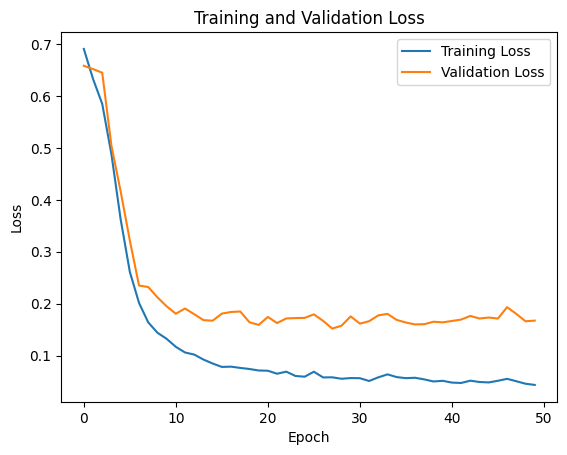

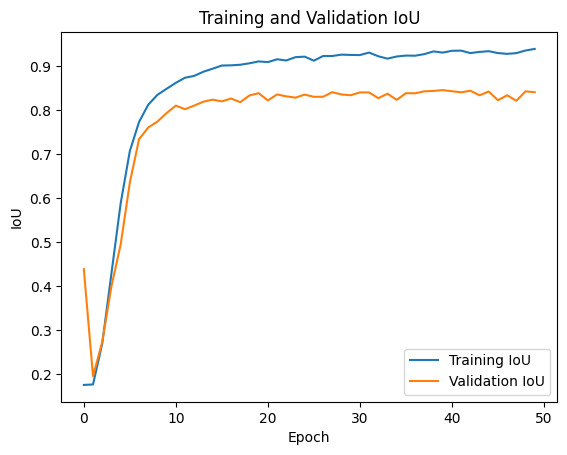

In [22]:
# Plotting training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation IoU
plt.plot(train_accs, label='Training IoU')
plt.plot(val_accs, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

### IOU and Dice Score

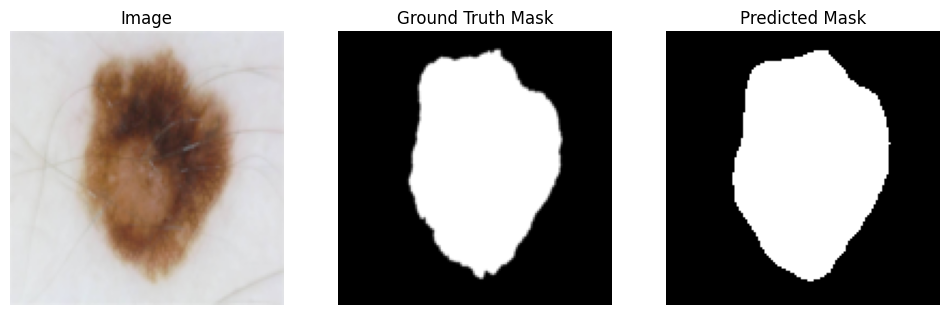

IoU: 0.9525504151838672, Dice Score: 1.0028335398358137


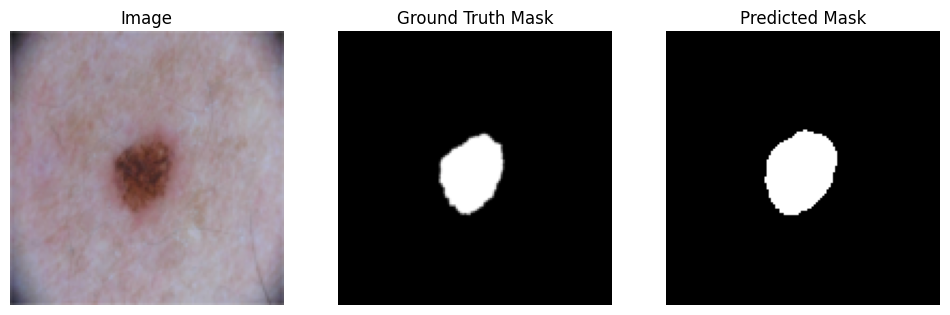

IoU: 0.898406374501992, Dice Score: 1.0084575119547485


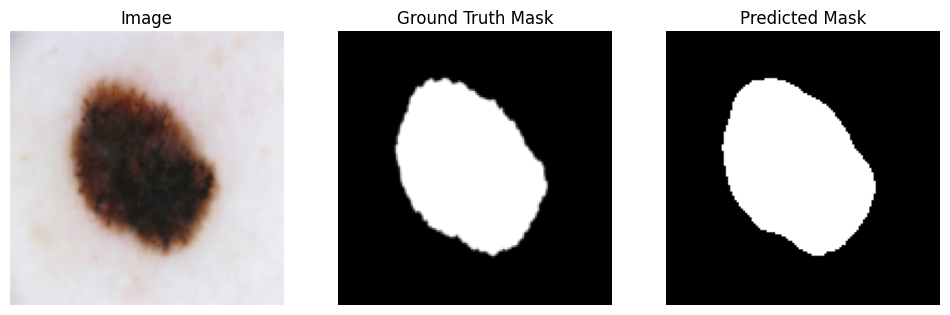

IoU: 0.956794425087108, Dice Score: 1.009083557327586


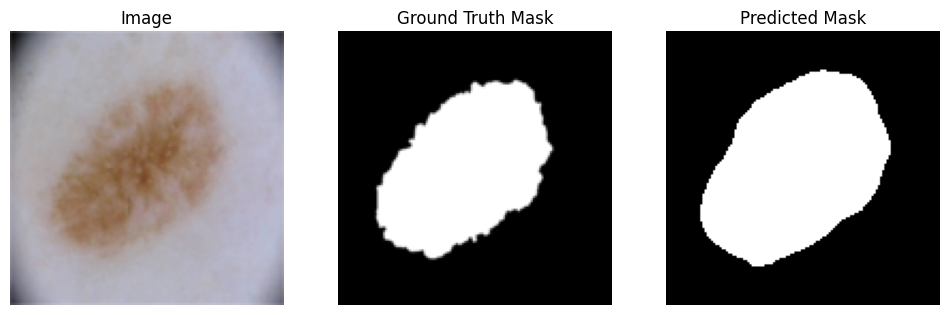

IoU: 0.8696515616537281, Dice Score: 0.9589897708701351


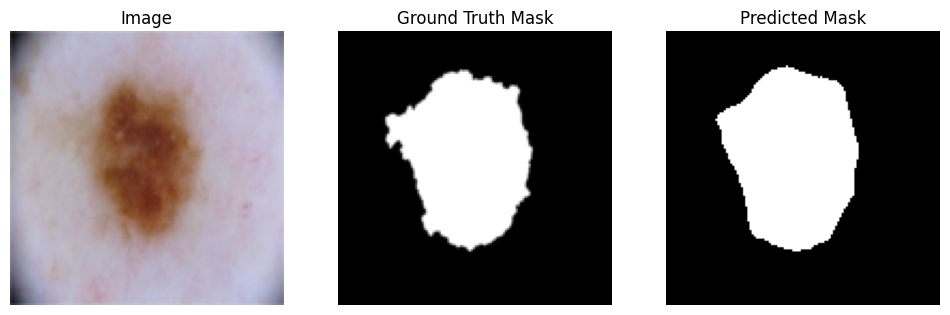

IoU: 0.9306560821853841, Dice Score: 1.0009152924711953


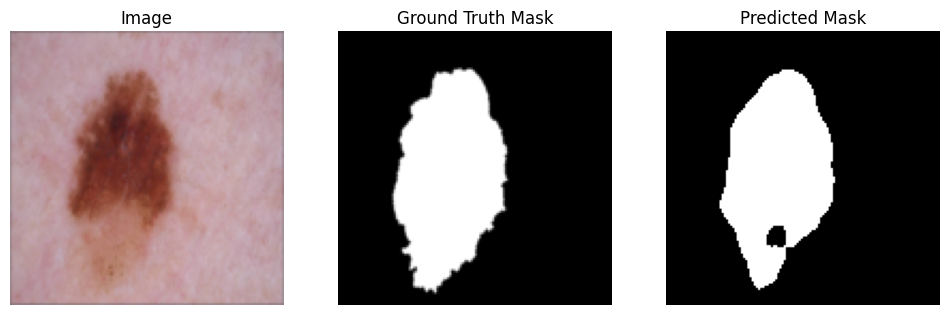

IoU: 0.8545979778526721, Dice Score: 0.9595662735103074


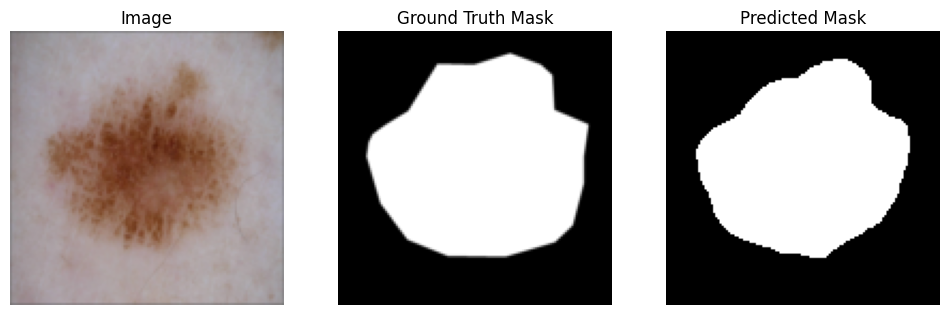

IoU: 0.8413029315960912, Dice Score: 0.9350522992611751


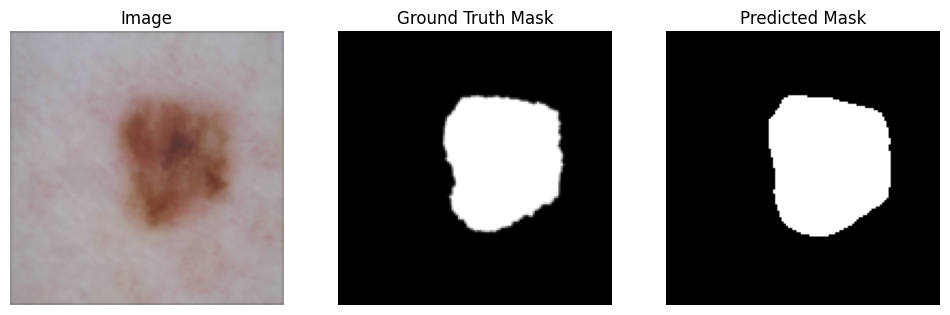

IoU: 0.9254522769806612, Dice Score: 0.9969902423143094


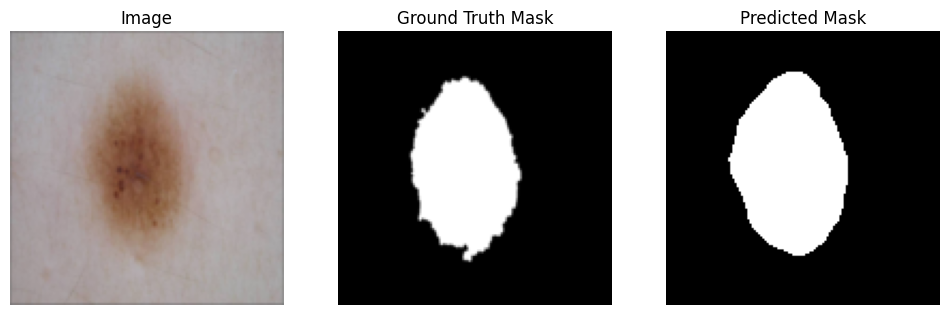

IoU: 0.9166902805327288, Dice Score: 0.9942023570228612


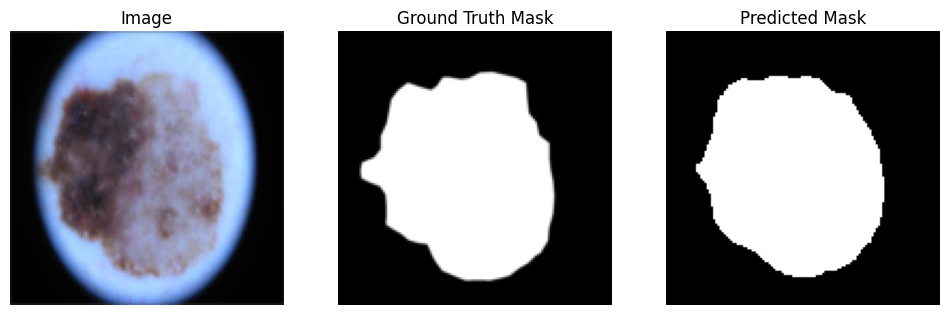

IoU: 0.9175394600973595, Dice Score: 0.9801894703439161
IoU: 0.8379035526138052, Dice Score: 0.9410817190821869
IoU: 0.9004289215686274, Dice Score: 0.988725477634604
IoU: 0.9013600950746071, Dice Score: 0.9700026415543913
IoU: 0.9483729363488883, Dice Score: 0.9939947220129256
IoU: 0.886192562633412, Dice Score: 0.9679375434173981
IoU: 0.9237830319888735, Dice Score: 0.9884442093338502
IoU: 0.8654353562005277, Dice Score: 0.9631302958102522
IoU: 0.9582477754962354, Dice Score: 1.0076978333415854
IoU: 0.8900255754475703, Dice Score: 0.9653607642656105
IoU: 0.8474378881987578, Dice Score: 0.9562570917984854
IoU: 0.46045034642032334, Dice Score: 0.6495113679924083
IoU: 0.8632305194805194, Dice Score: 0.9639118557881565
IoU: 0.8392258064516129, Dice Score: 0.9535379578160029
IoU: 0.9221668742216688, Dice Score: 1.008339755093248
IoU: 0.30455801104972374, Dice Score: 0.4872020311412803
IoU: 0.7583728813559322, Dice Score: 0.8838881601904072
IoU: 0.9482709750566893, Dice Score: 0.9985696428

In [23]:
import torch
import matplotlib.pyplot as plt

# Load the saved model for testing
loaded_model = SegmentationModel(1)  
loaded_model.load_state_dict(torch.load('trained_model_big_4.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Function to calculate IoU
def calculate_iou(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    union = torch.logical_or(gt_mask, predicted_mask).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

# Function to calculate Dice score
def calculate_dice(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    dice = 2 * intersection / (gt_mask.sum().item() + predicted_mask.sum().item())
    return dice

# Function to visualize image, ground truth mask, and predicted mask
def visualize_sample(image, gt_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(gt_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

iou_total = 0
dice_total = 0
num_samples = 0
num_visualized=0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, masks = data
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()

        for j in range(len(images)):
            if num_visualized < 10:  # Visualize only 10 images
                visualize_sample(images[j].cpu(), masks[j].cpu(), predicted_masks[j].cpu())
                num_visualized+=1
            iou = calculate_iou(masks[j], predicted_masks[j])
            dice = calculate_dice(masks[j], predicted_masks[j])
            iou_total += iou
            dice_total += dice
            num_samples += 1

            print(f"IoU: {iou}, Dice Score: {dice}")

# Calculate average IoU and Dice score
avg_iou = iou_total / num_samples
avg_dice = dice_total / num_samples

print(f"Average IoU: {avg_iou}, Average Dice Score: {avg_dice}")


## Model 2 with fine tuning and features taken from multiple layers

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class CustomSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomSegmentationModel, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.encoder = models.mobilenet_v2(pretrained=True).features

        # Fine-tuning MobileNetV2 encoder
        for param in self.encoder.parameters():
            param.requires_grad = True

        # Define decoder blocks
        self.decoder_block1 = DecoderBlock(2560, 512)  # Concatenate features, hence input channels are summed
        self.decoder_block2 = DecoderBlock(1024, 256)   # Concatenate features, hence input channels are summed
        self.decoder_block3 = DecoderBlock(512, 128)   # Concatenate features, hence input channels are summed
        self.decoder_block4 = DecoderBlock(128, 64)

        # Intermediate convolution layers for resizing feature maps
        self.conv1 = nn.Conv2d(160, 1280, kernel_size=1)  # Resize features[1] to match features[0]
        self.conv2 = nn.Conv2d(64, 512, kernel_size=1)    # Resize features[2] to match features[1]
        self.conv3 = nn.Conv2d(32, 256, kernel_size=1)    # Resize features[3] to match features[2]

        # Final convolution to get segmentation masks
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.final_conv1 = nn.Upsample(size=(128, 128), mode='bilinear', align_corners=True)

    def forward(self, x):
        # Forward pass through the encoder
        features = []
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i in {4, 7, 14, 18}:  # Layers to extract features from
                features.append(x)

        # Reverse features list to match decoder order
        features = features[::-1]

        # Resize feature maps if necessary
        features[1] = self.conv1(features[1])
        features[2] = self.conv2(features[2])
        features[3] = self.conv3(features[3])

        # Forward pass through the decoder with concatenated skip connections
        x = torch.cat([features[0], features[1]], dim=1)  # Concatenate along the channel dimension
        x = self.decoder_block1(x)
        x = torch.cat([x, features[2]], dim=1)  # Concatenate along the channel dimension
        x = self.decoder_block2(x)
        x = torch.cat([x, features[3]], dim=1)  # Concatenate along the channel dimension
        x = self.decoder_block3(x)
        x = self.decoder_block4(x)

        # Final convolution
        x = self.final_conv(x)
        x = self.final_conv1(x)

        return x

    def dice_loss(self, input, target, smooth=1):
        input = torch.sigmoid(input)
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

    def forward_with_dice_loss(self, x, target):
        output = self.forward(x)
        loss = self.dice_loss(output, target)
        return output, loss


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

num_classes = 1  # Example: 2 classes (foreground/background)
model = CustomSegmentationModel(num_classes)

# Print the model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)
summary(model, (3, 128,128))  # Adjust input shape as needed

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

### Training Loop

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define Dice loss function
def dice_loss(input, target, smooth=1):
    input = torch.sigmoid(input)
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Define combined loss function
def combined_loss(input, target, alpha=0.5):
    bce_loss = nn.BCEWithLogitsLoss()(input, target)
    dice = dice_loss(input, target)
    combined = alpha * bce_loss + (1 - alpha) * dice
    return combined
def calculate_iou(outputs, targets, threshold=0.5):
    # Convert outputs and targets to binary masks
    outputs = (outputs > threshold).long()
    targets = (targets > 0.5).long()
    
    intersection = (outputs & targets).float().sum((1, 2))
    union = (outputs | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add epsilon to avoid division by zero
    return iou.mean().item()

# # Define loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define loss function and optimizer with SGD and momentum
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Training loop
num_epochs = 50

# Initialize variables for best loss and best model weights
best_loss = float('inf')
best_weights = None

# Lists to store training and validation losses
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_iou_train = 0.0
    total_batches_train = 0
    
    for i, data in enumerate(tqdm(train_dataloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Calculate combined loss
        loss = combined_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate IoU for training accuracy
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()
        total_iou_train += calculate_iou(predicted_masks, labels)
        total_batches_train += 1
    
    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = total_iou_train / total_batches_train
    train_accs.append(train_acc)
    
    # Check if current epoch has the best validation loss
    if loss < best_loss:
        best_loss = loss
        best_weights = model.state_dict()

    # Validation
    model.eval()
    val_loss = 0.0
    total_iou_val = 0.0
    total_batches_val = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # Calculate combined loss for validation
            loss = combined_loss(outputs, labels)
            val_loss += loss.item()
            
            # Calculate IoU for validation accuracy
            predicted_masks = torch.sigmoid(outputs) > 0.5
            predicted_masks = predicted_masks.bool()
            total_iou_val += calculate_iou(predicted_masks, labels)
            total_batches_val += 1
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_acc = total_iou_val / total_batches_val
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Training IoU: {train_acc:.4f}, '
          f'Validation IoU: {val_acc:.4f}')

torch.save(model.state_dict(), 'trained_model_1.pth')


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [1/50], Training Loss: 0.6643, Validation Loss: 0.6607, Training IoU: 0.4821, Validation IoU: 0.4702


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [2/50], Training Loss: 0.6612, Validation Loss: 0.6573, Training IoU: 0.4824, Validation IoU: 0.4702


100%|██████████| 13/13 [00:48<00:00,  3.70s/it]


Epoch [3/50], Training Loss: 0.6566, Validation Loss: 0.6540, Training IoU: 0.4804, Validation IoU: 0.4702


100%|██████████| 13/13 [00:48<00:00,  3.73s/it]


Epoch [4/50], Training Loss: 0.6540, Validation Loss: 0.6508, Training IoU: 0.4820, Validation IoU: 0.4702


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [5/50], Training Loss: 0.6500, Validation Loss: 0.6474, Training IoU: 0.4810, Validation IoU: 0.4702


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [6/50], Training Loss: 0.6458, Validation Loss: 0.6433, Training IoU: 0.4815, Validation IoU: 0.4702


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [7/50], Training Loss: 0.6400, Validation Loss: 0.6368, Training IoU: 0.4803, Validation IoU: 0.4702


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [8/50], Training Loss: 0.6295, Validation Loss: 0.6236, Training IoU: 0.4807, Validation IoU: 0.4702


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [9/50], Training Loss: 0.6054, Validation Loss: 0.5890, Training IoU: 0.4812, Validation IoU: 0.4702


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch [10/50], Training Loss: 0.5343, Validation Loss: 0.5002, Training IoU: 0.4945, Validation IoU: 0.6030


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [11/50], Training Loss: 0.3853, Validation Loss: 0.3763, Training IoU: 0.7289, Validation IoU: 0.6517


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Epoch [12/50], Training Loss: 0.2617, Validation Loss: 0.3620, Training IoU: 0.7364, Validation IoU: 0.7116


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [13/50], Training Loss: 0.2308, Validation Loss: 0.2891, Training IoU: 0.7806, Validation IoU: 0.7022


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [14/50], Training Loss: 0.2119, Validation Loss: 0.2638, Training IoU: 0.7892, Validation IoU: 0.7336


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch [15/50], Training Loss: 0.2026, Validation Loss: 0.2914, Training IoU: 0.7973, Validation IoU: 0.7658


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Epoch [16/50], Training Loss: 0.1968, Validation Loss: 0.2473, Training IoU: 0.8034, Validation IoU: 0.7641


100%|██████████| 13/13 [00:48<00:00,  3.72s/it]


Epoch [17/50], Training Loss: 0.1892, Validation Loss: 0.2353, Training IoU: 0.8031, Validation IoU: 0.7800


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [18/50], Training Loss: 0.1806, Validation Loss: 0.2269, Training IoU: 0.8151, Validation IoU: 0.7777


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [19/50], Training Loss: 0.1737, Validation Loss: 0.2176, Training IoU: 0.8187, Validation IoU: 0.7978


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Epoch [20/50], Training Loss: 0.1689, Validation Loss: 0.2116, Training IoU: 0.8245, Validation IoU: 0.8066


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [21/50], Training Loss: 0.1580, Validation Loss: 0.2323, Training IoU: 0.8320, Validation IoU: 0.7992


100%|██████████| 13/13 [00:50<00:00,  3.86s/it]


Epoch [22/50], Training Loss: 0.1384, Validation Loss: 0.1783, Training IoU: 0.8469, Validation IoU: 0.8253


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Epoch [23/50], Training Loss: 0.1251, Validation Loss: 0.1646, Training IoU: 0.8591, Validation IoU: 0.8294


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [24/50], Training Loss: 0.1173, Validation Loss: 0.1672, Training IoU: 0.8668, Validation IoU: 0.8351


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [25/50], Training Loss: 0.1074, Validation Loss: 0.1579, Training IoU: 0.8758, Validation IoU: 0.8325


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [26/50], Training Loss: 0.1032, Validation Loss: 0.1671, Training IoU: 0.8791, Validation IoU: 0.8371


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [27/50], Training Loss: 0.1021, Validation Loss: 0.1644, Training IoU: 0.8805, Validation IoU: 0.8232


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch [28/50], Training Loss: 0.0980, Validation Loss: 0.2466, Training IoU: 0.8833, Validation IoU: 0.8039


100%|██████████| 13/13 [00:50<00:00,  3.88s/it]


Epoch [29/50], Training Loss: 0.0975, Validation Loss: 0.1611, Training IoU: 0.8864, Validation IoU: 0.8314


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [30/50], Training Loss: 0.0915, Validation Loss: 0.1573, Training IoU: 0.8888, Validation IoU: 0.8319


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [31/50], Training Loss: 0.0912, Validation Loss: 0.1549, Training IoU: 0.8912, Validation IoU: 0.8377


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Epoch [32/50], Training Loss: 0.0891, Validation Loss: 0.1683, Training IoU: 0.8905, Validation IoU: 0.8409


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Epoch [33/50], Training Loss: 0.0813, Validation Loss: 0.1558, Training IoU: 0.9010, Validation IoU: 0.8472


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [34/50], Training Loss: 0.0776, Validation Loss: 0.1610, Training IoU: 0.9042, Validation IoU: 0.8482


100%|██████████| 13/13 [00:50<00:00,  3.91s/it]


Epoch [35/50], Training Loss: 0.0807, Validation Loss: 0.1999, Training IoU: 0.9025, Validation IoU: 0.8341


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [36/50], Training Loss: 0.0804, Validation Loss: 0.2272, Training IoU: 0.9019, Validation IoU: 0.8241


100%|██████████| 13/13 [00:50<00:00,  3.86s/it]


Epoch [37/50], Training Loss: 0.0870, Validation Loss: 0.1666, Training IoU: 0.8945, Validation IoU: 0.8459


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [38/50], Training Loss: 0.0755, Validation Loss: 0.1768, Training IoU: 0.9060, Validation IoU: 0.8413


100%|██████████| 13/13 [00:48<00:00,  3.77s/it]


Epoch [39/50], Training Loss: 0.0761, Validation Loss: 0.1491, Training IoU: 0.9063, Validation IoU: 0.8489


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [40/50], Training Loss: 0.0686, Validation Loss: 0.1569, Training IoU: 0.9139, Validation IoU: 0.8511


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [41/50], Training Loss: 0.0692, Validation Loss: 0.1810, Training IoU: 0.9124, Validation IoU: 0.8449


100%|██████████| 13/13 [00:49<00:00,  3.80s/it]


Epoch [42/50], Training Loss: 0.0838, Validation Loss: 0.1643, Training IoU: 0.8976, Validation IoU: 0.8502


100%|██████████| 13/13 [00:50<00:00,  3.87s/it]


Epoch [43/50], Training Loss: 0.0705, Validation Loss: 0.1552, Training IoU: 0.9113, Validation IoU: 0.8523


100%|██████████| 13/13 [00:49<00:00,  3.77s/it]


Epoch [44/50], Training Loss: 0.0682, Validation Loss: 0.1819, Training IoU: 0.9137, Validation IoU: 0.8441


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [45/50], Training Loss: 0.0686, Validation Loss: 0.1615, Training IoU: 0.9132, Validation IoU: 0.8503


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


Epoch [46/50], Training Loss: 0.0668, Validation Loss: 0.1549, Training IoU: 0.9153, Validation IoU: 0.8521


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch [47/50], Training Loss: 0.0641, Validation Loss: 0.1642, Training IoU: 0.9181, Validation IoU: 0.8517


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch [48/50], Training Loss: 0.0633, Validation Loss: 0.1672, Training IoU: 0.9190, Validation IoU: 0.8485


100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Epoch [49/50], Training Loss: 0.0652, Validation Loss: 0.1639, Training IoU: 0.9159, Validation IoU: 0.8516


100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Epoch [50/50], Training Loss: 0.0689, Validation Loss: 0.1506, Training IoU: 0.9118, Validation IoU: 0.8509


### Curves

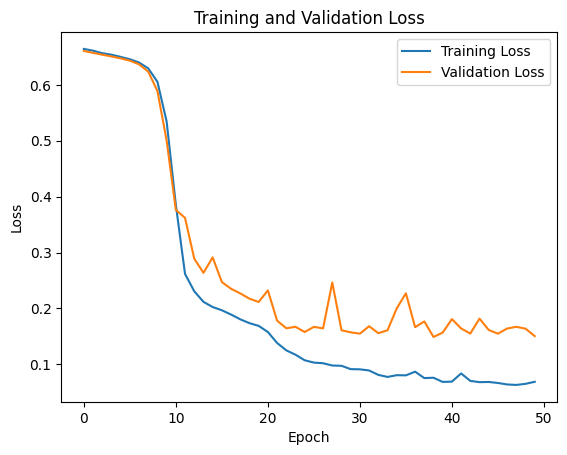

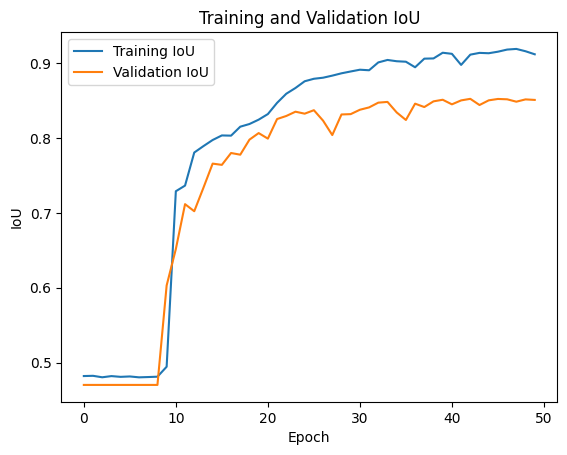

In [26]:
# Plotting training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation IoU
plt.plot(train_accs, label='Training IoU')
plt.plot(val_accs, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

### IOU and Dice Score

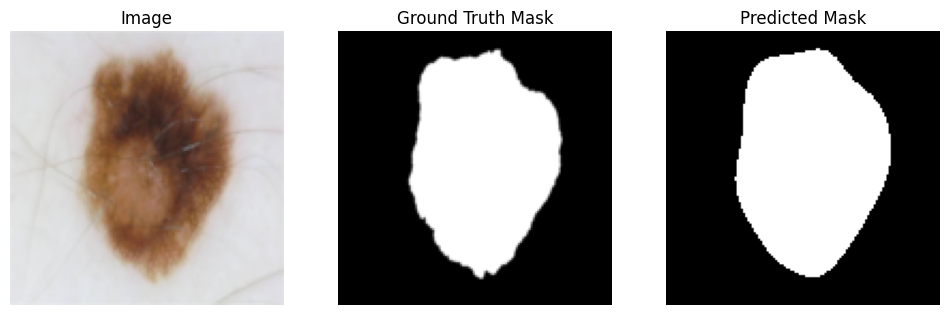

IoU: 0.9666780587833219, Dice Score: 1.0104279891215475


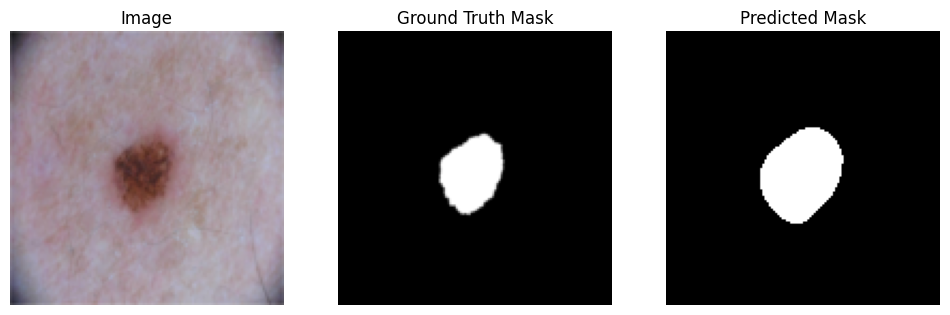

IoU: 0.7279236276849642, Dice Score: 0.8905670240888705


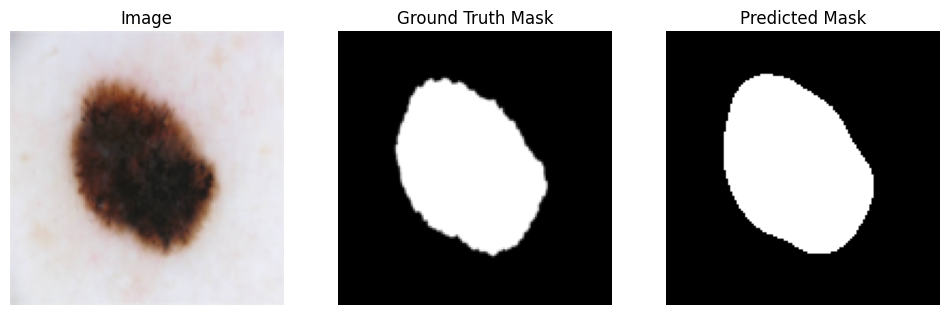

IoU: 0.9614943845977538, Dice Score: 1.0111061073793002


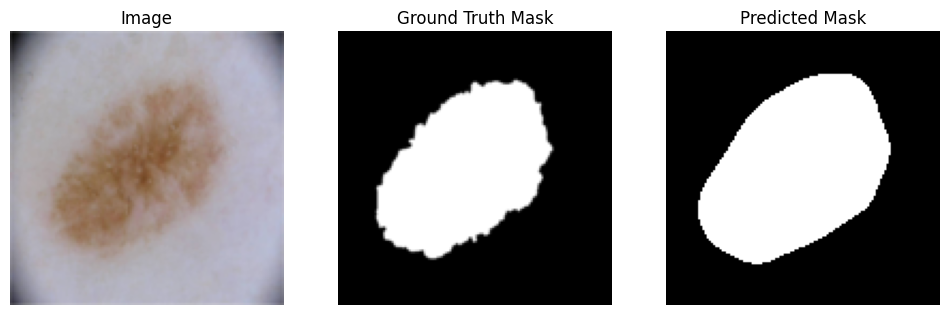

IoU: 0.8831168831168831, Dice Score: 0.9670517108299685


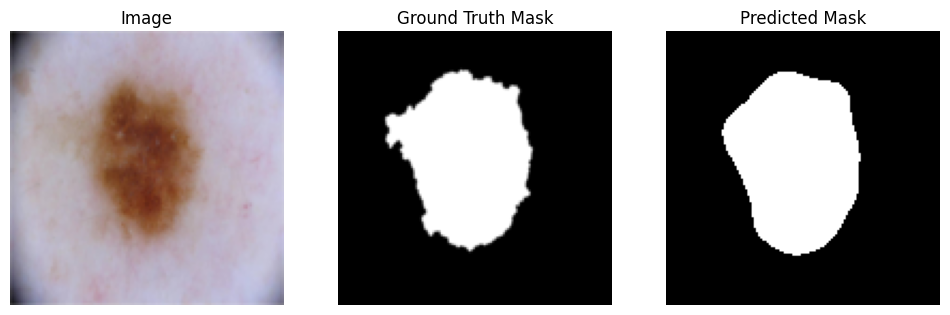

IoU: 0.9209726443768997, Dice Score: 0.9957392319607347


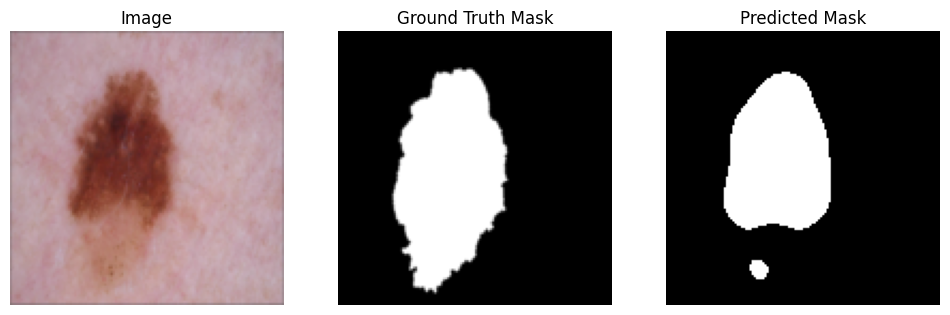

IoU: 0.715179215780611, Dice Score: 0.8711862910477429


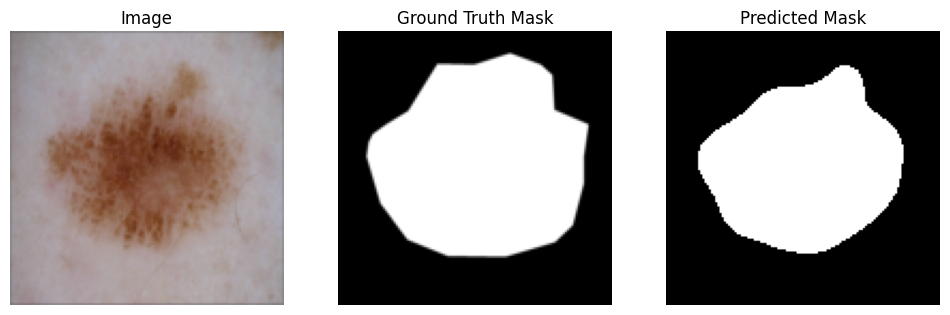

IoU: 0.7559609120521172, Dice Score: 0.8820315362474442


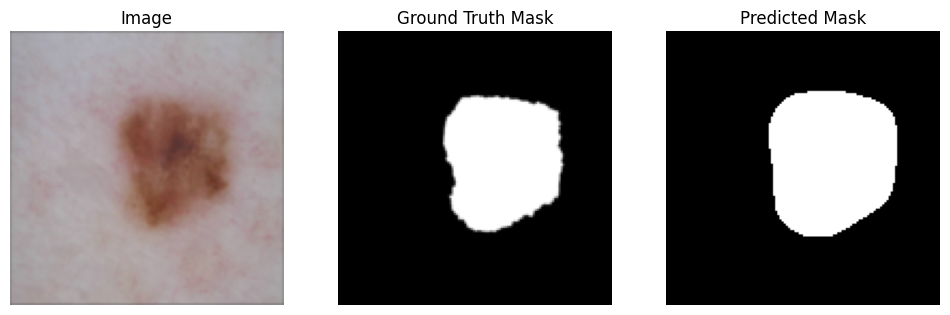

IoU: 0.9016681299385426, Dice Score: 0.9816926244831874


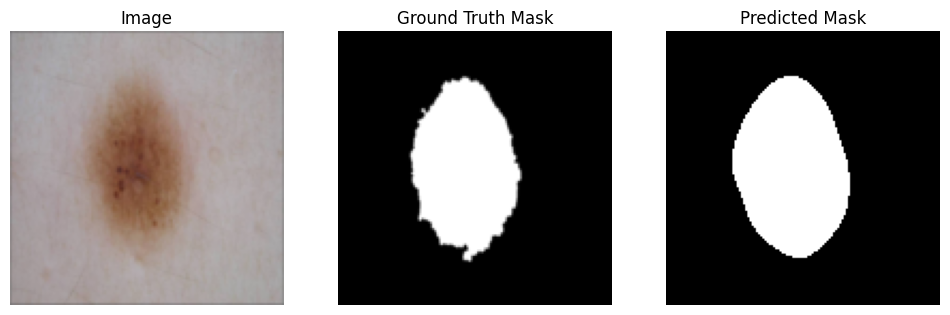

IoU: 0.9326840446863363, Dice Score: 1.0032770596645726


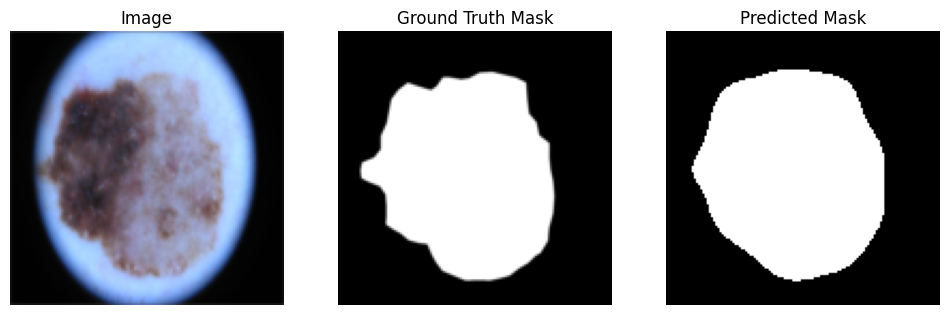

IoU: 0.9366217378835675, Dice Score: 0.9898151605164739
IoU: 0.7575307307848169, Dice Score: 0.8910283916586184
IoU: 0.8788723667905824, Dice Score: 0.9770920066541146
IoU: 0.9305237646425205, Dice Score: 0.9863565328560114
IoU: 0.960167714884696, Dice Score: 1.0001448189423952
IoU: 0.9115531580130366, Dice Score: 0.9820461320230343
IoU: 0.9415262636273538, Dice Score: 0.9984758785362656
IoU: 0.9350877192982456, Dice Score: 1.0017209492690096
IoU: 0.947265306122449, Dice Score: 1.0005653943700463
IoU: 0.859451290397582, Dice Score: 0.9479160497320757
IoU: 0.8927729772191674, Dice Score: 0.9827663992180268
IoU: 0.6507547939616483, Dice Score: 0.8182876989964011
IoU: 0.7841035120147875, Dice Score: 0.9125982572888709
IoU: 0.92, Dice Score: 0.9991766018683408
IoU: 0.9146264908976773, Dice Score: 1.0046536934272556
IoU: 0.6448170731707317, Dice Score: 0.8457147570954767
IoU: 0.6926211614029981, Dice Score: 0.8410023724086134
IoU: 0.9582226158842634, Dice Score: 1.0048634355359423
IoU: 0.87

In [27]:
import torch
import matplotlib.pyplot as plt

# Load the saved model for testing
loaded_model = CustomSegmentationModel(1)  # Replace YourModelClass with the class of your model
loaded_model.load_state_dict(torch.load('trained_model_1.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Function to calculate IoU
def calculate_iou(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    union = torch.logical_or(gt_mask, predicted_mask).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

# Function to calculate Dice score
def calculate_dice(gt_mask, predicted_mask):
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    dice = 2 * intersection / (gt_mask.sum().item() + predicted_mask.sum().item())
    return dice

# Function to visualize image, ground truth mask, and predicted mask
def visualize_sample(image, gt_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(gt_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

iou_total = 0
dice_total = 0
num_samples = 0
num_visualized=0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, masks = data
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs) > 0.5
        predicted_masks = predicted_masks.bool()

        for j in range(len(images)):
            if num_visualized < 10:  # Visualize only 10 images
                visualize_sample(images[j].cpu(), masks[j].cpu(), predicted_masks[j].cpu())
                num_visualized+=1
            iou = calculate_iou(masks[j], predicted_masks[j])
            dice = calculate_dice(masks[j], predicted_masks[j])
            iou_total += iou
            dice_total += dice
            num_samples += 1

            print(f"IoU: {iou}, Dice Score: {dice}")

# Calculate average IoU and Dice score
avg_iou = iou_total / num_samples
avg_dice = dice_total / num_samples

print(f"Average IoU: {avg_iou}, Average Dice Score: {avg_dice}")
